In [1]:
# Загрузка необходимых библиотек и модулей

import warnings
warnings.filterwarnings("ignore")

import re
import math
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from treelib import Node, Tree

from nltk import FreqDist
from wordcloud import WordCloud,STOPWORDS

from sklearn.model_selection import train_test_split

import spacy
from spacy import displacy
from spacy.util import minibatch
from spacy.training import Example
from spacy.glossary import GLOSSARY
from spacy.tokenizer import Tokenizer
from spacy.pipeline import EntityRecognizer, EntityRuler
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex

In [2]:
# Фиксируем сид

seed = 42
random.seed(seed)
np.random.seed(seed)
spacy.util.fix_random_seed(seed)

In [3]:
# Загрузка тренировочного датасета

train = pd.read_json('train.json')
train.head()

,id,text,label,extracted_part
0,809436509,Извещение о проведении открытого конкурса в эл...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...
1,854885310,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,обеспечение исполнения контракта,{'text': ['Поставщик должен предоставить обесп...
2,4382157,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...
3,184555082,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...
4,211645258,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...


# EDA

In [4]:
# Посмотрим информацию о датасете

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1799 entries, 0 to 1798
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1799 non-null   int64 
 1   text            1799 non-null   object
 2   label           1799 non-null   object
 3   extracted_part  1799 non-null   object
dtypes: int64(1), object(3)
memory usage: 56.3+ KB


In [5]:
# Проверим датасет на отсутствие дублирующихся строк

print('Количество дублирующихся записей - ', len(train[train.id.duplicated()].values))

Количество дублирующихся записей -  0


In [6]:
# Выведем пример extracted_part для понимания его структуры

train.extracted_part[0]

{'text': ['Размер обеспечения исполнения контракта 6593.25 Российский рубль'],
 'answer_start': [1279],
 'answer_end': [1343]}

In [7]:
# Т.к. в некоторых текстах отсутствуют объекты для извлечения, создаем столбец flag с метками для успешно найденных фрагментов
# для категорий в label 1 и 2 соответственно и меткой 0 для отсутствующих к извлечению фрагментов в тексте
# Также добавляем столбцы с количеством слов и символов в извлеченных фрагментов

train['flag'] = train.apply(lambda x: 0 if len(x.extracted_part['text'][0]) == 0 
                            else (1 if x.label == 'обеспечение исполнения контракта' else 2), axis=1)
train['len_extra_text'] = train.extracted_part.apply(lambda x: len(x['text'][0].split()))
train['len_extra_text_char'] = train.extracted_part.apply(lambda x: len(list(x['text'][0])))
train.head()

,id,text,label,extracted_part,flag,len_extra_text,len_extra_text_char
0,809436509,Извещение о проведении открытого конкурса в эл...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...,1,7,64
1,854885310,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,обеспечение исполнения контракта,{'text': ['Поставщик должен предоставить обесп...,1,13,96
2,4382157,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...,1,5,46
3,184555082,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...,1,5,46
4,211645258,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...,1,5,46


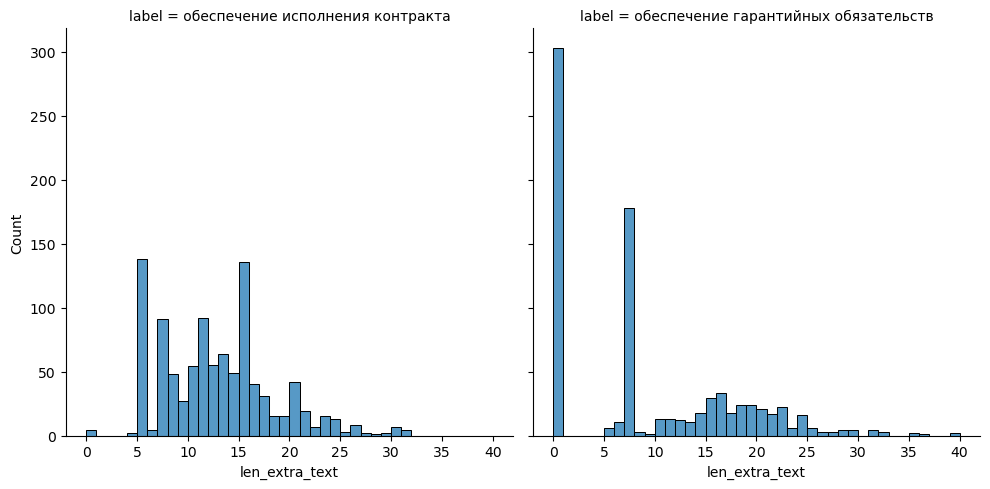

In [8]:
# Строим графики распределения количества слов в извлеченном фрагменте для каждой из категорий

sns.displot(train, x="len_extra_text", binwidth=1, col="label")

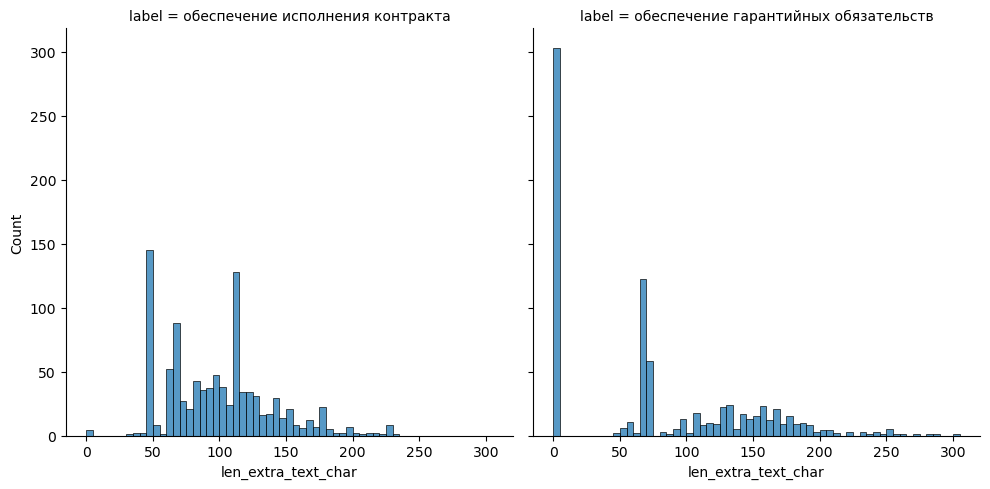

In [9]:
# Строим графики распределения количества символов в извлеченном фрагменте для каждой из категорий

sns.displot(train, x="len_extra_text_char", binwidth=5, col="label")

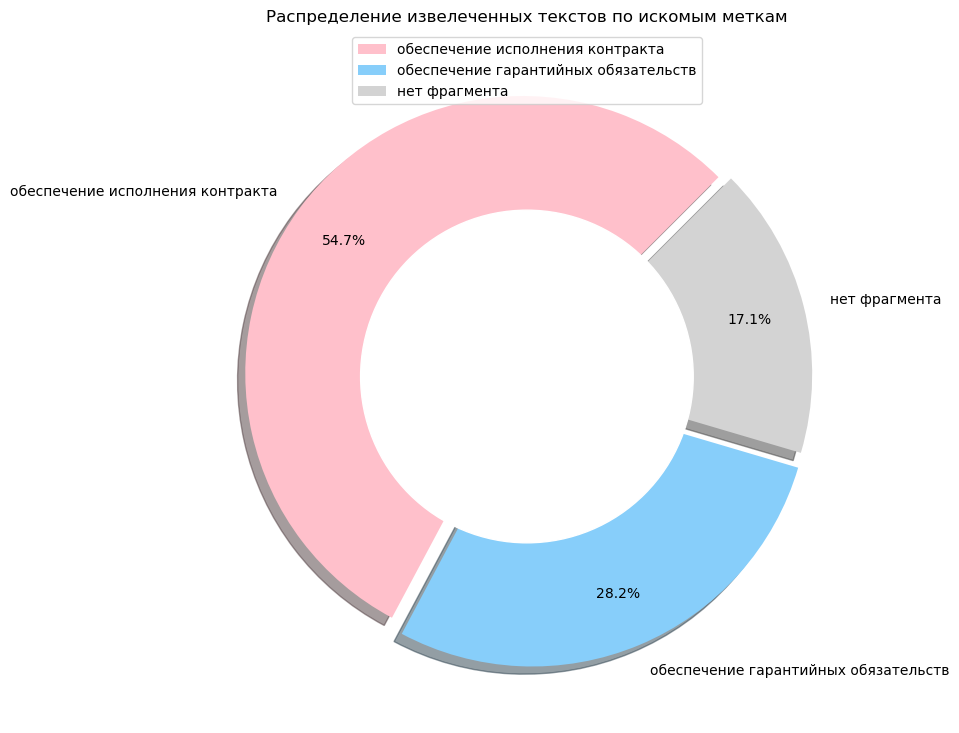

In [10]:
# Строим график распределения фрагментов, соответствующих меткам label в датасете

size = train.flag.value_counts()
colors = ['pink', 'lightskyblue', 'lightgray']
labels = train.label.unique().tolist() + ['нет фрагмента']
explode = [0.02, 0.05, 0.03] 

plt.figure(figsize=(9, 9))
donut = plt.Circle((0,0), 0.6, color = 'white')
plt.pie(size, colors = colors, labels = labels, shadow = True, 
        explode = explode, autopct = '%.1f%%', pctdistance=0.8, startangle=45)

plt.title('Распределение извелеченных текстов по искомым меткам', fontsize = 12)
plt.legend(loc='upper center')
p = plt.gcf()
p.gca().add_artist(donut)
plt.show()

In [11]:
# Из графиков видно, что чуть более 300 текстов не имеют извлеченного фрагмента для соответствующего label (4 И 303 соответственно)
# Соотношение количества меток label, для которых в тексте есть соответствующий извлеченный фрагмент примерно 2 к 1 для label
# 'обеспечение исполнения контракта' и 'обеспечение гарантийных обязательств' соответственно
# Количество слов в извлеченных фрагментах от 4 до 31 (наиболее часто встречающиеся - 5 и 15 слов) для 'обеспечение 
# исполнения контракта'и от 5 до 40 (наиболее часто встречающееся - 7 слов) для 'обеспечение гарантийных обязательств'

In [12]:
# Для удобства поместим извлеченные фрагменты в отдельный столбец и посмотрим количество уникальных извлеченных фрагментов 
# в целом и для каждой категории label отдельно, а также выведем извлеченные фрагменты

train['extra_text'] = train .extracted_part.apply(lambda x: x['text'][0])
print('Всего извлеченных уникальных фрагментов', len(train['extra_text'].unique()))
print('Уникальных фрагментов для метки "обеспечение исполнения контракта"', len(train.extra_text[train.flag == 1].unique()))
print('Уникальных фрагментов для метки "обеспечение гарантийных обязательств"', len(train.extra_text[train.flag == 2].unique()))

Всего извлеченных уникальных фрагментов 1045
Уникальных фрагментов для метки "обеспечение исполнения контракта" 598
Уникальных фрагментов для метки "обеспечение гарантийных обязательств" 446


In [13]:
for elem in train.extra_text.unique():
    print([elem])

['Размер обеспечения исполнения контракта 6593.25 Российский рубль']
['Поставщик должен предоставить обеспечение исполнения контракта в размере 10 % от цены Контракта.']
['Размер обеспечения исполнения контракта 10.00%']
['Размер обеспечения исполнения контракта устанавливается в размере 5 (пять) процентов от цены, по которой заключается контракт и составляет ___']
['Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта']
['Размер обеспечения исполнения контракта 5.00%']
['Поставщик при заключении Контракта должен предоставить Заказчику обеспечение исполнения Контракта в размере 5 % от начальной (максимальной) цены Контракта']
['Размер обеспечения исполнения контракта 11635.97 Российский рубль']
['Обеспечение исполнения Контракта устанавливается в размере 5 процентов от Цены Контракта.']
['Размер обеспечения исполнения контракта 1.00%']
['Размер обеспечения исполнения контракта составляет 10 (Десять) процентов цены контракта, ч

In [14]:
# Выведем 5 наиболее часто встречающихся фрагментов

train.extracted_part.astype(str).value_counts().head(5)

{'text': [''], 'answer_start': [0], 'answer_end': [0]}                                                                                                                                                         307
{'text': ['Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта'], 'answer_start': [1310], 'answer_end': [1422]}                                    14
{'text': ['не предусмотрено увеличенное от первоначально установленного обеспечения исполнения договора в 1,5 (полтора) раза, но не менее 5% (пяти) от НМЦ'], 'answer_start': [1146], 'answer_end': [1289]}      6
{'text': ['Размер обеспечения исполнения контракта 5.00%'], 'answer_start': [1303], 'answer_end': [1348]}                                                                                                        5
{'text': ['Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта'], 'answer_start': [1303], 'answ

In [15]:
# Синтаксические конструкции многих предложений очень похожи, чтобы понять ее лучше, выведем график дерева, для примера возьмем 
# предложения, начинающиеся со слова "Размер", а также по 10 наиболее популярных первых слов в предложении 

train['first_word'] = train.extra_text.apply(lambda x: x.split()[0].lower() if len(x) != 0 else '')

In [16]:
# 10 наиболее частых первых слов в фрагментах 'обеспечение исполнения контракта'

train.first_word[train.flag == 1].value_counts().head(10)

размер         568
обеспечение    214
поставщик       51
не              27
сумма           21
в               11
если            11
договор          8
исполнитель      6
участник         6
Name: first_word, dtype: int64

In [17]:
# 10 частых первых слов в фрагментах 'обеспечение гарантийных обязательств'

train.first_word[train.flag == 2].value_counts().head(10)

размер           351
обеспечение       73
подрядчик         11
сумма             11
поставщик          5
требование         5
заказчиком         5
предоставляет      4
если               4
в                  4
Name: first_word, dtype: int64

In [18]:
# График дерева структуры предложений, первое слово в которых "Размер" в извлеченных сущностях для метки 
# 'обеспечение исполнения контракта'

tree = Tree()
tree.create_node('Размер', 'Размер')
for k in range(len(train.extra_text[(train.first_word == 'размер') & (train.flag == 1)].unique())):
    text = train.extra_text[(train.first_word == 'размер') & (train.flag == 1)].unique().tolist()[k].split()
    for i in range(1, len(text)):
        try:
            tree.create_node(text[i], text[i], parent=text[i-1])
        except:
            pass
tree.show()

Размер
├── обеспечеrrия
├── обеспечение
├── обеспечения
│   └── исполнения
│       ├── Государственного
│       ├── Договора
│       │   ├── 123
│       │   │   └── 810,00
│       │   └── равен
│       ├── Договора,
│       │   └── условия,
│       │       └── порядок
│       │           ├── его
│       │           │   └── предоставления:
│       │           └── предоставления
│       ├── Контракта
│       │   ├── 50
│       │   ├── составляет__________
│       │   └── указанной
│       ├── государственного
│       ├── договора,
│       │   ├── а
│       │   │   └── также
│       │   │       └── требования
│       │   │           └── к
│       │   │               └── такому
│       │   │                   └── обеспечению
│       │   ├── гарантийных
│       │   │   └── обязательств:
│       │   └── срок
│       │       └── действия
│       ├── договора:
│       │   ├── 0%
│       │   ├── 14
│       │   │   └── 850
│       │   └── установлен:
│       ├── контракта
│       │   ├── (без
│ 

In [19]:
# График дерева структуры предложений, первое слово в которых "Размер" в извлеченных сущностях для метки 
# 'обеспечение гарантийных обязательств'

tree = Tree()
tree.create_node('Размер', 'Размер')
for k in range(len(train.extra_text[(train.first_word == 'размер') & (train.flag == 2)].unique())):
    text = train.extra_text[(train.first_word == 'размер') & (train.flag == 2)].unique().tolist()[k].split()
    for i in range(1, len(text)):
        try:
            tree.create_node(text[i], text[i], parent=text[i-1])
        except:
            pass
tree.show()

Размер
└── обеспечения
    ├── Гарантийных
    ├── Исполнение
    │   └── гарантийного
    │       └── обязательства
    │           └── обеспечиваются
    │               └── внесением
    │                   └── денежных
    │                       └── средств
    │                           └── участником
    ├── гарантийных
    │   ├── обязательств
    │   │   ├── -
    │   │   │   ├── 15%
    │   │   │   ├── ________
    │   │   │   │   └── (_____________)
    │   │   │   └── для
    │   │   │       └── сделок
    │   │   │           └── с
    │   │   │               └── ценой
    │   │   ├── 0,2%
    │   │   ├── 1%
    │   │   │   ├── (102,00
    │   │   │   ├── (Один
    │   │   │   │   └── процент)
    │   │   │   └── начальной
    │   │   │       ├── (максимальной)
    │   │   │       │   ├── цены
    │   │   │       │   │   ├── Договора
    │   │   │       │   │   ├── Договора,
    │   │   │       │   │   ├── Договора.
    │   │   │       │   │   ├── Контракта
    │   │   │  

In [20]:
# Структура многих предложений имеет схожий характер и синтаксические формы, что вероятно позволит создать шаблон, в случае
# необходимости повышения точности модели, который можно будет включить в него

In [84]:
# Создаем функцию showWordCloud для построения облака наиболее частых слов в извлеченных сущностях для каждой из меток label 
# Также создаем функцию words_frequency для вывода столбчатой диаграммы 50 наиболее частых слов

def showWordCloud(data, label):
    text = ' '.join(data.extra_text)
    text = ' '.join([word for word in text.lower().split() if len(word) > 2])
    wordcloud = WordCloud(stopwords = STOPWORDS, 
                          background_color='white', max_words=100, 
                          contour_width=3, contour_color='dodgerblue',
                          colormap='Dark2', collocations=False
                         ).generate(text)
    plt.figure(figsize = (10,5))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.title('100 наиболее частых слов в сущностях, относящихся к "'+label+'"', pad = 14, weight = 'bold')
    plt.show()
    return wordcloud

def words_frequency(text, top_n = 50):
    words = ' '.join([sent for sent in text])
    words = words.lower().split()
    words = [re.sub(r'[^А-Яа-яё]', '', word) for word in words if len(re.sub(r'[^А-Яа-яё]', '', word)) > 2]
    freq_dist = FreqDist(words)
    words_df = pd.DataFrame({'наиболее частые слова в извлеченных сущностях':list(freq_dist.keys()), 
                             'количество':list(freq_dist.values())})
  
    d = words_df.nlargest(columns='количество', n=top_n) 
    plt.figure(figsize=(15,5))
    ax = sns.barplot(data=d, x='наиболее частые слова в извлеченных сущностях', y='количество')
    plt.xticks(rotation=75)
    plt.show();
    return d

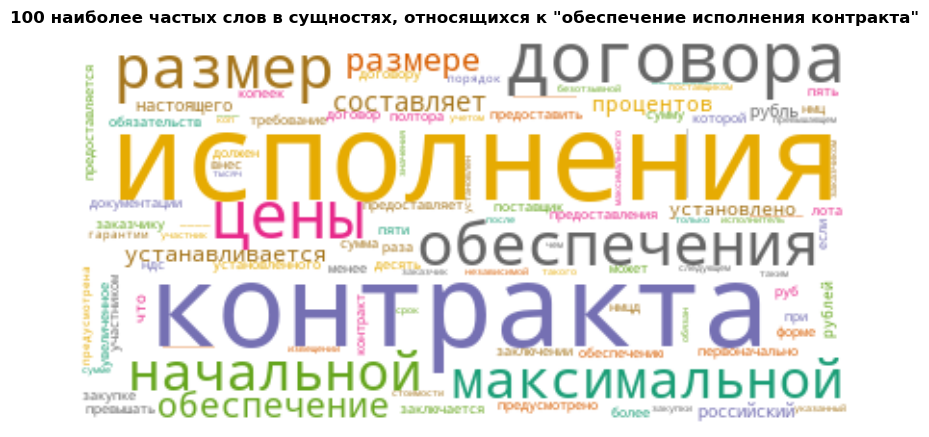

In [80]:
# Выводим облако слов и диаграмму для фрагментов, относящихся к 'обеспечение исполнения контракта'

showWordCloud(train[train.flag == 1], 'обеспечение исполнения контракта')

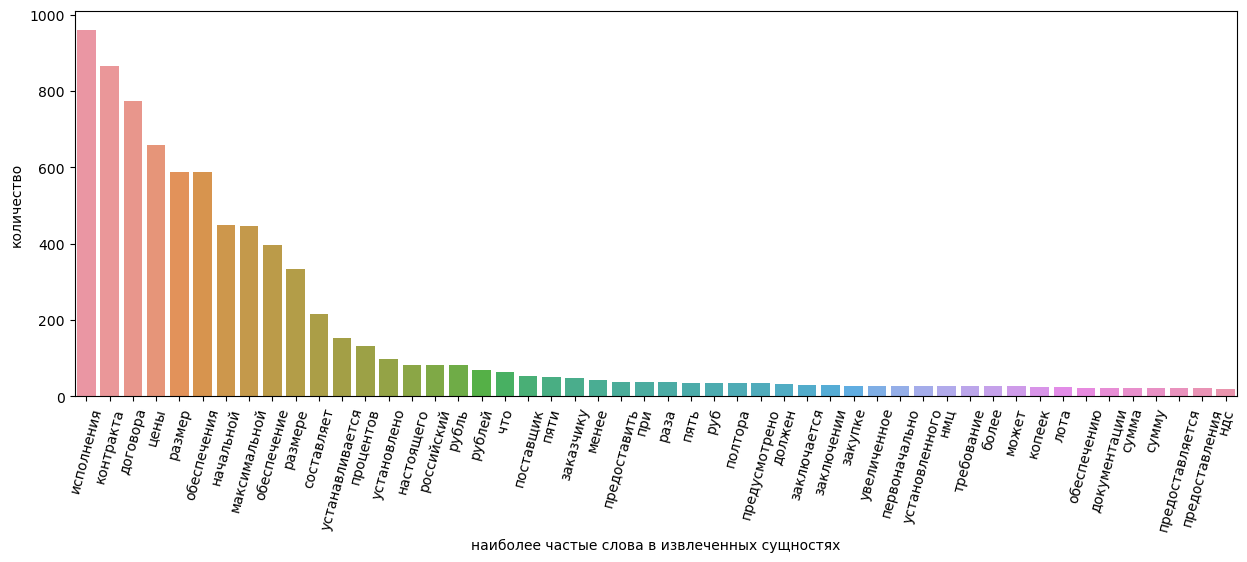

In [85]:
cont_most_freq_words = words_frequency(train.extra_text[train.flag == 1].tolist())

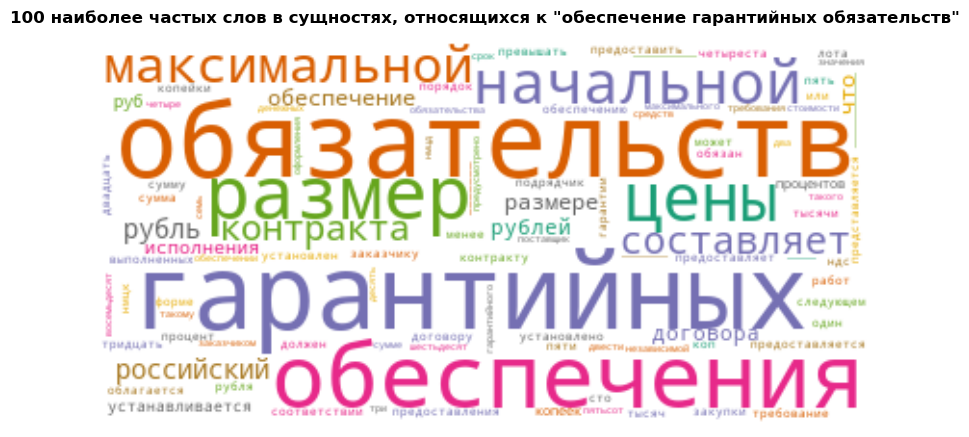

In [82]:
# Выводим облако слов и диаграмму для фрагментов, относящихся к 'обеспечение гарантийных обязательств'

showWordCloud(train[train.flag == 2], 'обеспечение гарантийных обязательств')

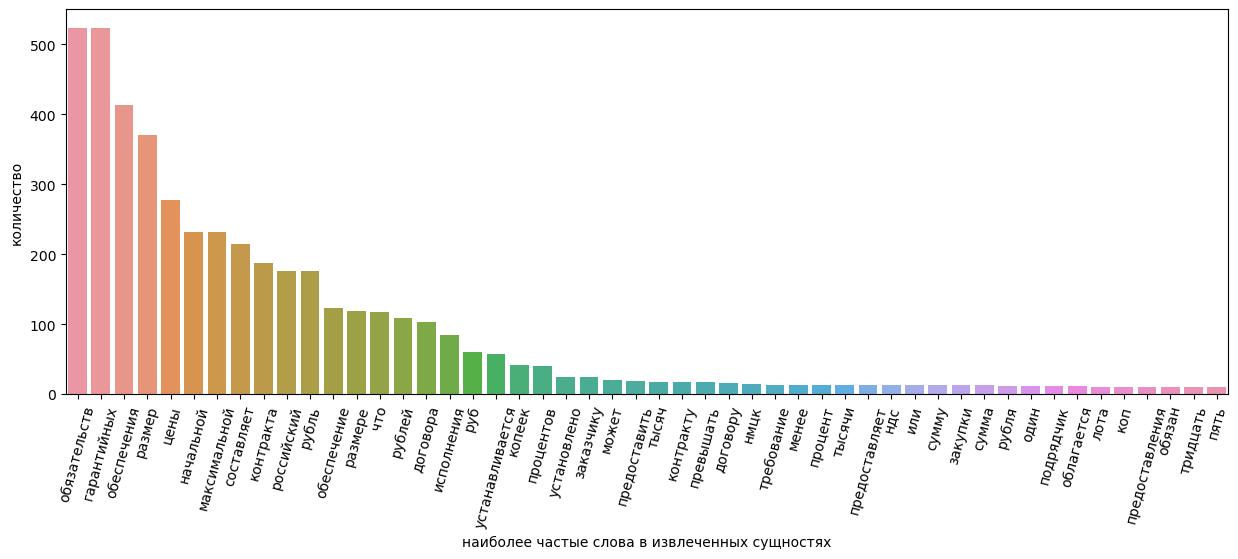

In [86]:
# Выводим диаграмму для фрагментов, относящихся к 'обеспечение гарантийных обязательств'

warr_most_freq_words = words_frequency(train.extra_text[train.flag == 2].tolist())

In [31]:
# Загружаем предобученную модель Spacy 'ru_core_news_lg'

nlp = spacy.load('ru_core_news_lg')
print(nlp.pipe_names)

['tok2vec', 'morphologizer', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


In [32]:
# Создадим функцию, которая разделит все текст на токены и распределит на 4 группы - слова, цифры и числительные, пунктуация и
# все не попавшее в остальные группы. Цель этой функции - проверка, все ли слова, символы и цифры корректно токенизируются или
# есть необходимость в создании кастомного токенизатора

def check_tokenizer(model, data):
    words = []
    puncts = []
    nums = []
    garb = []
    for i in tqdm(range(len(data))):
        doc = nlp(data[i])
        for i, elem in enumerate([token.text for token in doc]):
            word = re.sub(r'[^А-Яа-яё]', '', elem)
            punct = ''.join(re.findall(r'(?:[^\s\w]|_)+', elem))
            num = ''.join(re.findall(r'\b\d+(?:[,.]\d+)*\b', elem))
            if model(elem)[0].pos_ == 'NUM' or elem == num:
                nums.append(elem)
            elif elem == punct:
                puncts.append(elem)
            elif elem == ' ':
                pass
            else:
                if elem == word:
                    words.append(elem)
                else:
                    garb.append(elem)
    return words, puncts, nums, garb
words, puncts, nums, garb = check_tokenizer(nlp, train['extra_text'].tolist())

100%|██████████████████████████████████████████████████████████████████████████████| 1799/1799 [01:31<00:00, 19.63it/s]


In [33]:
set(words)

{'Акта',
 'Бенефициар',
 'В',
 'Восемнадцать',
 'Гарантийное',
 'Гарантийные',
 'Гарантийных',
 'Генеральный',
 'Государственного',
 'Государственному',
 'Девяносто',
 'Договор',
 'Договора',
 'Договорной',
 'Договору',
 'Доля',
 'Дополнительного',
 'Если',
 'ЗАКАЗЧИКОМ',
 'Заказчик',
 'Заказчика',
 'Заказчиком',
 'Заказчику',
 'Закона',
 'Извещении',
 'Извещения',
 'Исполнение',
 'Исполнителем',
 'Исполнитель',
 'Конкурса',
 'Контракт',
 'Контракта',
 'Контракте',
 'Контрактом',
 'Контракту',
 'Лот',
 'МСП',
 'НДС',
 'НМЦ',
 'НМЦД',
 'НМЦК',
 'На',
 'Начальной',
 'Не',
 'Необходимость',
 'Обеспечение',
 'ПОДРЯДЧИКА',
 'Подрядчик',
 'Подрядчиком',
 'Подрядчику',
 'Покупателю',
 'Полтора',
 'Порядок',
 'Поставщик',
 'Поставщиком',
 'Постановления',
 'Правительства',
 'Предоставление',
 'Предусмотрено',
 'При',
 'Приложения',
 'Принципала',
 'Принять',
 'Продукции',
 'Проценты',
 'РФ',
 'Работ',
 'Разделе',
 'Размер',
 'Российский',
 'Специальной',
 'Срок',
 'Субподрядчик',
 'Сумма',
 'Т

In [34]:
set(puncts)

{'%',
 '(',
 ')',
 '):',
 ',',
 '-',
 '-------',
 '.',
 '/',
 ':',
 ';',
 '=',
 '_',
 '«',
 '»',
 '\u200b\u200b\u200b\u200b\u200b\u200b\u200b\u200b\u200b\u200b\u200b',
 '–',
 '…',
 '№',
 '☐',
 '☒'}

In [35]:
# Некоторые символы не разделены на отдельные токены. Т.к. в некоторых случаях в разметке конец фрагмента находится в центре
# последовательности символов вроде "_", важно, а условием задания является точное посимвольное совпадение, важно разделить
# такие фрагменты посимвольно. Исправим это в кастомном токенизаторе с помощью регулярных выражений

In [36]:
set(nums)

{'0',
 '0,00',
 '0,01',
 '0,1',
 '0,2',
 '0,5',
 '0,50',
 '0,75',
 '0,9',
 '0.00',
 '0.1',
 '0.5',
 '0.50',
 '00',
 '000',
 '000,00',
 '000.00',
 '002,52',
 '006',
 '008,44',
 '017',
 '019,85',
 '025,00',
 '03',
 '039',
 '060',
 '067',
 '08',
 '080,00',
 '080,88',
 '099,87',
 '0__%',
 '1',
 '1,00',
 '1,5',
 '1.00',
 '10',
 '10,00',
 '10.00',
 '100',
 '100.00',
 '1011647.09',
 '10142.69',
 '102',
 '102,00',
 '103',
 '1049760.00',
 '105',
 '10579.18',
 '10584.09',
 '10655.54',
 '106604.00',
 '107',
 '108,52',
 '11',
 '11.12.2014',
 '11116.20',
 '11145.00',
 '112364.19',
 '11257.14',
 '1133.76',
 '113630.08',
 '115000.00',
 '11599.38',
 '11600,00',
 '11635.97',
 '11680000.00',
 '116841.19',
 '11796.28',
 '11860.25',
 '11862.90',
 '11944.27',
 '11950.00',
 '12',
 '120',
 '120711.45',
 '1209045.29',
 '123',
 '12350.00',
 '12366.84',
 '1239.41',
 '125',
 '1258.65',
 '127',
 '1276.20',
 '13',
 '13087.50',
 '131250.00',
 '132',
 '1333',
 '134',
 '13450.67',
 '135',
 '1350122.66',
 '1352',
 '13

In [37]:
# В списке чисел и числительных присутствуют последовательности из цифр и пунктуации как например '0__%', которые тоже 
# следует разделить на отдельные токены. Также добавим это условие в пользовательский токенизатор

In [38]:
set(garb)

{'5___%',
 '765,00руб',
 'Zi',
 'l00',
 'Контракта(цены',
 'Н(М)ЦД',
 'НМЦД-',
 'ОДi',
 'договора-',
 'лота),что',
 'начальной-',
 'обеспечеrrия',
 'оставляет:228',
 'п.',
 'процент(ов',
 'пять)%',
 'руб.',
 'руб.75',
 'составляет________руб',
 'сумму________руб',
 'це-'}

In [39]:
# Многие фрагменты были отсеяны из других списков, так как они состоят из последовательности слов/цифр/пунктуации, которые
# также необходимо выделить в отдельные токены.

# Data preparation

In [40]:
# Разделим данные на тренировочную и валидационную выборки с использованием stratify, чтобы количество сущностей для каждой из
# меток и текстов без искомой сущности было пропорциональным 

train_sample, val_sample = train_test_split(train, train_size=0.9, stratify=train.flag, random_state=seed)
print(f'Размер тренировочной выборки - {train_sample.shape[0]}\nРазмер валидационной выборки - {val_sample.shape[0]}')

Размер тренировочной выборки - 1619
Размер валидационной выборки - 180


In [41]:
# Приводим формат данных в соответствие с форматом входных данных модели Spacy.

def examples_preparation(data):
    examples = []
    for _, row in data.iterrows():
        entities = []
        if row.flag != 0:
            entities.append((row['extracted_part']['answer_start'][0],
                             row['extracted_part']['answer_end'][0],
                             row['label']))
        spacy_entry = (row['text'], {'entities': entities})
        examples.append(spacy_entry)
    return examples

train_data = examples_preparation(train_sample)
print('Объект тренировочной выборки:\n', train_data[:1])
val_data = examples_preparation(val_sample)
print('Объект валидационной выборки:\n', val_data[:1])

Объект тренировочной выборки:
 [('Идентификационный код закупки: 222632107909963210100100010310000323 КОНТРАКТ №____ на поставку продуктов питания город ______________ «___»__________ 20__ год Государственное казенное учреждение Самарской области \'\'Тольяттинский социальный приют для лиц без определенного места жительства и  который является казенным учреждением; 2) осуществления закупки услуги по предоставлению кредита; 3) заключения бюджетным учреждением, государственным, муниципальным унитарными предприятиями контракта, предметом которого является выдача независимой гарантии. Заказчик вправе установить, что настоящий раздел не применяется в случае заключения Контракта по результатам проведения электронного запроса котировок (за исключением случая, предусмотренного подпунктом "б" пункта 2 части 10 статьи 24 Федерального закона «О контрактной системе в сфере закупок товаров, работ, услуг для обеспечения государственных и муниципальных нужд»). По контрактам, подлежащим казначейскому с

In [42]:
# Сохраняем индексы строк тренировочных данных

train_idx = train_sample.index.tolist()

# Modeling

In [43]:
# Удаляем из ранее загруженной предобученной модели все компоненты, кроме 'tok2vec', 'morphologizer', а затем создаем новый 
# пайплайн ner, который будем обучать на нашем датасете

for pipe in ['parser', 'attribute_ruler', 'lemmatizer', 'ner']:
    nlp.remove_pipe(pipe)

ner = EntityRecognizer(nlp.vocab, 'ner')
nlp.add_pipe('ner', name="ner", last=True)
print(nlp.pipe_names)

['tok2vec', 'morphologizer', 'ner']


In [44]:
# Отключаем все пайплайны, кроме ner

disabled_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
nlp.disable_pipes(*disabled_pipes)
print(nlp.pipe_names)

['ner']


In [45]:
# Создаем экземпляр пользовательского токенизатора для исправления ошибок токенизации, выявленных в EDA с помощью 
# регулярных выражений и добавляем токенизатор в пайплайн обработки текста

def custom_tokenizer(nlp):
    prefix_re = compile_prefix_regex(nlp.Defaults.prefixes + ["[0-9]+\\.[0-9]+\\.[0-9]+\\.", "[0-9]+\\.[0-9]+\\.", "^\."])
    suffix_re = compile_suffix_regex(nlp.Defaults.suffixes + ["-"])
    infix_re = compile_infix_regex(nlp.Defaults.infixes + ["\u200b", r"[\(\)\:\-\_]", r"(?<=\d\s)[,\.]+(?=[\D])", 
                                                           r"(?<=\D)[,\.]+(?=[\d])", r"(?<=\D)[,\.]+(?=[\D])",
                                                           "\[|\]"])

    tokenizer = Tokenizer(nlp.vocab, prefix_search=prefix_re.search,
                          suffix_search=suffix_re.search,
                          infix_finditer=infix_re.finditer,
                          token_match=None)
    return tokenizer

nlp.tokenizer = custom_tokenizer(nlp)

In [6]:
# Для валидации модели создаем 2 функции extract_text и accuracy_score, первая из которых извлекает предсказанный моделью
# фрагмент/сущность, вторая - рассчитывает accuracy. В этом случае мы не можем использовать встроенный инструмент Scorer, 
# так как он позволяет рассчитать только метрику precision, которая не учитывает ложно-отрицательные предсказания модели

def extract_text(model, document_text, form_field):
    # Обработка текста документа с помощью модели SpaCy
    doc = model(document_text)
    # Извлечение куска текста, соответствующего нужной сущности
    for ent in doc.ents:
        if ent.label_ == form_field:
            return ent.text
    return ''

def accuracy_score(model, val_data):
    val_data['predict'] = val_data.apply(lambda x: extract_text(model, x.text, x.label), axis=1)
    val_data['matches'] = val_data.apply(lambda x: 1 if x.extra_text == x.predict else 0, axis=1)
    return round(val_data['matches'].mean(), 4)

In [337]:
# Тренируем модель NER Spacy на 500 итерациях/эпохах с размером банча 64. После каждой эпохи вычисленные потери и accuracy
# сравниваются с предыдущими лучшими результатами, при улучшении метрики и уменьшении потерь - новая модель записывается 
# на диск

n_iter = 500
size=64

optimizer = nlp.begin_training()

test_accuracy = dict()
loss_history = dict()
best_score = -1
loss_min = 1e7
for i in range(n_iter):
    losses = {}
    random.shuffle(train_data)
    batches = tqdm(minibatch(train_data, size=size), 
                   leave=True, total=math.ceil(len(train_data)/size))
    for batch in batches:
        batches.set_description(f"Epoch {i+1}/{n_iter}" % batch, refresh=True)
        try:
            batches.set_postfix_str(f"train_losses={round(losses['ner'], 2)}")
        except:
            batches.set_postfix_str(f"train_losses={0.00}")
        for text, annotations in batch:
            example = Example.from_dict(nlp.make_doc(text), annotations)
            nlp.update([example], drop=0.2, sgd=optimizer, losses=losses)
    accuracy = accuracy_score(nlp, val_sample[['text', 'label', 'extra_text']])
    print(81*' ', f"val_accuracy={round(accuracy, 4)}")
    if accuracy >= best_score and losses['ner'] <= loss_min:
        print(f'model with accuracy = {accuracy} and losses = {round(losses["ner"], 0)} saved to disk')
        loss_min = losses['ner']
        best_score = accuracy
        nlp.meta["name"] = "Kontur_nlp_v2"
        nlp.to_disk('C://Users/Konstantin/Documents/Стажировки и тестовые/Kontur_test_task/solution/Kontur_nlp_v2')
    test_accuracy[i+1] = accuracy
    loss_history[i+1] = round(losses['ner'], 2)

Epoch 1/500: 100%|███████████████████████████████████████████████| 26/26 [01:59<00:00,  4.59s/it, train_losses=14012.4]


                                                                                  val_accuracy=0.6444
model with accuracy = 0.6444 and losses = 14124.0 saved to disk


Epoch 2/500: 100%|███████████████████████████████████████████████| 26/26 [01:55<00:00,  4.44s/it, train_losses=2522.75]


                                                                                  val_accuracy=0.6389


Epoch 3/500: 100%|███████████████████████████████████████████████| 26/26 [02:03<00:00,  4.74s/it, train_losses=2173.91]


                                                                                  val_accuracy=0.6722
model with accuracy = 0.6722 and losses = 2253.0 saved to disk


Epoch 4/500: 100%|███████████████████████████████████████████████| 26/26 [01:56<00:00,  4.46s/it, train_losses=2132.58]


                                                                                  val_accuracy=0.6778
model with accuracy = 0.6778 and losses = 2149.0 saved to disk


Epoch 5/500: 100%|███████████████████████████████████████████████| 26/26 [01:55<00:00,  4.44s/it, train_losses=1980.17]


                                                                                  val_accuracy=0.6778
model with accuracy = 0.6778 and losses = 2003.0 saved to disk


Epoch 6/500: 100%|███████████████████████████████████████████████| 26/26 [01:55<00:00,  4.45s/it, train_losses=1670.57]


                                                                                  val_accuracy=0.6722


Epoch 7/500: 100%|████████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=1704.8]


                                                                                  val_accuracy=0.6833
model with accuracy = 0.6833 and losses = 1722.0 saved to disk


Epoch 8/500: 100%|███████████████████████████████████████████████| 26/26 [01:56<00:00,  4.49s/it, train_losses=1399.53]


                                                                                  val_accuracy=0.6778


Epoch 9/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=1396.83]


                                                                                  val_accuracy=0.6833
model with accuracy = 0.6833 and losses = 1406.0 saved to disk


Epoch 10/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.43s/it, train_losses=1511.97]


                                                                                  val_accuracy=0.6778


Epoch 11/500: 100%|██████████████████████████████████████████████| 26/26 [01:56<00:00,  4.47s/it, train_losses=1498.04]


                                                                                  val_accuracy=0.6944


Epoch 12/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=1239.03]


                                                                                  val_accuracy=0.7111
model with accuracy = 0.7111 and losses = 1249.0 saved to disk


Epoch 13/500: 100%|██████████████████████████████████████████████| 26/26 [01:56<00:00,  4.47s/it, train_losses=1151.03]


                                                                                  val_accuracy=0.7444
model with accuracy = 0.7444 and losses = 1157.0 saved to disk


Epoch 14/500: 100%|██████████████████████████████████████████████| 26/26 [01:56<00:00,  4.46s/it, train_losses=1082.64]


                                                                                  val_accuracy=0.7278


Epoch 15/500: 100%|███████████████████████████████████████████████| 26/26 [01:55<00:00,  4.46s/it, train_losses=1278.8]


                                                                                  val_accuracy=0.7611


Epoch 16/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.43s/it, train_losses=1044.67]


                                                                                  val_accuracy=0.75
model with accuracy = 0.75 and losses = 1062.0 saved to disk


Epoch 17/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=1130.01]


                                                                                  val_accuracy=0.7389


Epoch 18/500: 100%|██████████████████████████████████████████████| 26/26 [01:53<00:00,  4.38s/it, train_losses=1126.79]


                                                                                  val_accuracy=0.7222


Epoch 19/500: 100%|██████████████████████████████████████████████| 26/26 [01:53<00:00,  4.35s/it, train_losses=1047.19]


                                                                                  val_accuracy=0.7


Epoch 20/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=1081.67]


                                                                                  val_accuracy=0.7667


Epoch 21/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=809.32]


                                                                                  val_accuracy=0.7167


Epoch 22/500: 100%|███████████████████████████████████████████████| 26/26 [01:55<00:00,  4.43s/it, train_losses=923.62]


                                                                                  val_accuracy=0.7


Epoch 23/500: 100%|████████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=900.8]


                                                                                  val_accuracy=0.7556
model with accuracy = 0.7556 and losses = 921.0 saved to disk


Epoch 24/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=1051.68]


                                                                                  val_accuracy=0.75


Epoch 25/500: 100%|███████████████████████████████████████████████| 26/26 [01:55<00:00,  4.42s/it, train_losses=913.74]


                                                                                  val_accuracy=0.7444


Epoch 26/500: 100%|███████████████████████████████████████████████| 26/26 [01:53<00:00,  4.38s/it, train_losses=810.67]


                                                                                  val_accuracy=0.7556
model with accuracy = 0.7556 and losses = 819.0 saved to disk


Epoch 27/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=959.03]


                                                                                  val_accuracy=0.7444


Epoch 28/500: 100%|███████████████████████████████████████████████| 26/26 [01:53<00:00,  4.38s/it, train_losses=891.97]


                                                                                  val_accuracy=0.7444


Epoch 29/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=811.42]


                                                                                  val_accuracy=0.7556
model with accuracy = 0.7556 and losses = 818.0 saved to disk


Epoch 30/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=803.26]


                                                                                  val_accuracy=0.7444


Epoch 31/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=842.53]


                                                                                  val_accuracy=0.6667


Epoch 32/500: 100%|███████████████████████████████████████████████| 26/26 [01:53<00:00,  4.37s/it, train_losses=881.61]


                                                                                  val_accuracy=0.7056


Epoch 33/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=785.45]


                                                                                  val_accuracy=0.7


Epoch 34/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=867.14]


                                                                                  val_accuracy=0.7611


Epoch 35/500: 100%|███████████████████████████████████████████████| 26/26 [01:53<00:00,  4.36s/it, train_losses=826.66]


                                                                                  val_accuracy=0.75


Epoch 36/500: 100%|███████████████████████████████████████████████| 26/26 [01:53<00:00,  4.38s/it, train_losses=884.72]


                                                                                  val_accuracy=0.7444


Epoch 37/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=686.56]


                                                                                  val_accuracy=0.7667
model with accuracy = 0.7667 and losses = 697.0 saved to disk


Epoch 38/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=775.84]


                                                                                  val_accuracy=0.75


Epoch 39/500: 100%|███████████████████████████████████████████████| 26/26 [01:53<00:00,  4.38s/it, train_losses=875.78]


                                                                                  val_accuracy=0.6389


Epoch 40/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=832.76]


                                                                                  val_accuracy=0.7444


Epoch 41/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=766.33]


                                                                                  val_accuracy=0.7611


Epoch 42/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=732.56]


                                                                                  val_accuracy=0.7333


Epoch 43/500: 100%|███████████████████████████████████████████████| 26/26 [01:53<00:00,  4.37s/it, train_losses=737.63]


                                                                                  val_accuracy=0.7278


Epoch 44/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=756.85]


                                                                                  val_accuracy=0.7611


Epoch 45/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=714.83]


                                                                                  val_accuracy=0.7333


Epoch 46/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=731.27]


                                                                                  val_accuracy=0.75


Epoch 47/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=690.16]


                                                                                  val_accuracy=0.7111


Epoch 48/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=768.28]


                                                                                  val_accuracy=0.7


Epoch 49/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=817.19]


                                                                                  val_accuracy=0.7333


Epoch 50/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=705.87]


                                                                                  val_accuracy=0.7444


Epoch 51/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=753.82]


                                                                                  val_accuracy=0.7889


Epoch 52/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=768.38]


                                                                                  val_accuracy=0.7556


Epoch 53/500: 100%|███████████████████████████████████████████████| 26/26 [01:53<00:00,  4.37s/it, train_losses=821.43]


                                                                                  val_accuracy=0.7722


Epoch 54/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=825.47]


                                                                                  val_accuracy=0.75


Epoch 55/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=712.68]


                                                                                  val_accuracy=0.7722


Epoch 56/500: 100%|███████████████████████████████████████████████| 26/26 [01:55<00:00,  4.43s/it, train_losses=718.24]


                                                                                  val_accuracy=0.7222


Epoch 57/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=652.74]


                                                                                  val_accuracy=0.7611


Epoch 58/500: 100%|███████████████████████████████████████████████| 26/26 [01:53<00:00,  4.37s/it, train_losses=734.49]


                                                                                  val_accuracy=0.7556


Epoch 59/500: 100%|███████████████████████████████████████████████| 26/26 [01:53<00:00,  4.37s/it, train_losses=631.88]


                                                                                  val_accuracy=0.7444


Epoch 60/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=668.97]


                                                                                  val_accuracy=0.7167


Epoch 61/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=762.74]


                                                                                  val_accuracy=0.7833


Epoch 62/500: 100%|███████████████████████████████████████████████| 26/26 [01:53<00:00,  4.37s/it, train_losses=672.33]


                                                                                  val_accuracy=0.7444


Epoch 63/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=791.23]


                                                                                  val_accuracy=0.7444


Epoch 64/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=950.85]


                                                                                  val_accuracy=0.7167


Epoch 65/500: 100%|███████████████████████████████████████████████| 26/26 [01:53<00:00,  4.37s/it, train_losses=665.63]


                                                                                  val_accuracy=0.75


Epoch 66/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=769.54]


                                                                                  val_accuracy=0.7333


Epoch 67/500: 100%|███████████████████████████████████████████████| 26/26 [01:53<00:00,  4.36s/it, train_losses=689.43]


                                                                                  val_accuracy=0.7389


Epoch 68/500: 100%|███████████████████████████████████████████████| 26/26 [01:53<00:00,  4.38s/it, train_losses=878.48]


                                                                                  val_accuracy=0.7389


Epoch 69/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=658.47]


                                                                                  val_accuracy=0.7944
model with accuracy = 0.7944 and losses = 691.0 saved to disk


Epoch 70/500: 100%|███████████████████████████████████████████████| 26/26 [01:53<00:00,  4.37s/it, train_losses=665.98]


                                                                                  val_accuracy=0.7556


Epoch 71/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=677.31]


                                                                                  val_accuracy=0.7222


Epoch 72/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=750.38]


                                                                                  val_accuracy=0.7556


Epoch 73/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=671.48]


                                                                                  val_accuracy=0.7556


Epoch 74/500: 100%|███████████████████████████████████████████████| 26/26 [01:53<00:00,  4.38s/it, train_losses=823.09]


                                                                                  val_accuracy=0.7333


Epoch 75/500: 100%|███████████████████████████████████████████████| 26/26 [01:57<00:00,  4.53s/it, train_losses=685.45]


                                                                                  val_accuracy=0.7056


Epoch 76/500: 100%|███████████████████████████████████████████████| 26/26 [02:13<00:00,  5.14s/it, train_losses=699.82]


                                                                                  val_accuracy=0.7167


Epoch 77/500: 100%|███████████████████████████████████████████████| 26/26 [02:09<00:00,  5.00s/it, train_losses=703.31]


                                                                                  val_accuracy=0.7611


Epoch 78/500: 100%|███████████████████████████████████████████████| 26/26 [02:15<00:00,  5.23s/it, train_losses=670.51]


                                                                                  val_accuracy=0.75


Epoch 79/500: 100%|███████████████████████████████████████████████| 26/26 [02:07<00:00,  4.91s/it, train_losses=629.66]


                                                                                  val_accuracy=0.7278


Epoch 80/500: 100%|███████████████████████████████████████████████| 26/26 [02:12<00:00,  5.08s/it, train_losses=692.58]


                                                                                  val_accuracy=0.7444


Epoch 81/500: 100%|███████████████████████████████████████████████| 26/26 [02:06<00:00,  4.88s/it, train_losses=749.05]


                                                                                  val_accuracy=0.7278


Epoch 82/500: 100%|███████████████████████████████████████████████| 26/26 [01:55<00:00,  4.45s/it, train_losses=686.29]


                                                                                  val_accuracy=0.7389


Epoch 83/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=644.95]


                                                                                  val_accuracy=0.6833


Epoch 84/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=760.69]


                                                                                  val_accuracy=0.7333


Epoch 85/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=646.27]


                                                                                  val_accuracy=0.7611


Epoch 86/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=644.76]


                                                                                  val_accuracy=0.7278


Epoch 87/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=671.67]


                                                                                  val_accuracy=0.7667


Epoch 88/500: 100%|████████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=631.6]


                                                                                  val_accuracy=0.75


Epoch 89/500: 100%|███████████████████████████████████████████████| 26/26 [01:53<00:00,  4.38s/it, train_losses=630.65]


                                                                                  val_accuracy=0.7722


Epoch 90/500: 100%|███████████████████████████████████████████████| 26/26 [01:53<00:00,  4.38s/it, train_losses=726.19]


                                                                                  val_accuracy=0.7


Epoch 91/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=795.58]


                                                                                  val_accuracy=0.7167


Epoch 92/500: 100%|███████████████████████████████████████████████| 26/26 [01:53<00:00,  4.38s/it, train_losses=559.34]


                                                                                  val_accuracy=0.7278


Epoch 93/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=811.89]


                                                                                  val_accuracy=0.7278


Epoch 94/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=714.14]


                                                                                  val_accuracy=0.7056


Epoch 95/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=603.78]


                                                                                  val_accuracy=0.75


Epoch 96/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=689.79]


                                                                                  val_accuracy=0.7056


Epoch 97/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=662.62]


                                                                                  val_accuracy=0.7333


Epoch 98/500: 100%|███████████████████████████████████████████████| 26/26 [01:53<00:00,  4.37s/it, train_losses=610.77]


                                                                                  val_accuracy=0.7778


Epoch 99/500: 100%|███████████████████████████████████████████████| 26/26 [01:55<00:00,  4.44s/it, train_losses=680.05]


                                                                                  val_accuracy=0.7389


Epoch 100/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=548.87]


                                                                                  val_accuracy=0.7056


Epoch 101/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=535.09]


                                                                                  val_accuracy=0.6944


Epoch 102/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=647.94]


                                                                                  val_accuracy=0.6889


Epoch 103/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=566.78]


                                                                                  val_accuracy=0.7611


Epoch 104/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=604.03]


                                                                                  val_accuracy=0.7


Epoch 105/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=542.71]


                                                                                  val_accuracy=0.7722


Epoch 106/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=734.73]


                                                                                  val_accuracy=0.7333


Epoch 107/500: 100%|███████████████████████████████████████████████| 26/26 [01:55<00:00,  4.43s/it, train_losses=609.7]


                                                                                  val_accuracy=0.7667


Epoch 108/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=575.61]


                                                                                  val_accuracy=0.7389


Epoch 109/500: 100%|██████████████████████████████████████████████| 26/26 [01:56<00:00,  4.48s/it, train_losses=596.74]


                                                                                  val_accuracy=0.6722


Epoch 110/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=543.33]


                                                                                  val_accuracy=0.6889


Epoch 111/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=579.79]


                                                                                  val_accuracy=0.7222


Epoch 112/500: 100%|██████████████████████████████████████████████| 26/26 [01:53<00:00,  4.36s/it, train_losses=762.62]


                                                                                  val_accuracy=0.7722


Epoch 113/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.43s/it, train_losses=628.38]


                                                                                  val_accuracy=0.7222


Epoch 114/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=682.6]


                                                                                  val_accuracy=0.75


Epoch 115/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=576.33]


                                                                                  val_accuracy=0.7056


Epoch 116/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.42s/it, train_losses=566.94]


                                                                                  val_accuracy=0.7333


Epoch 117/500: 100%|██████████████████████████████████████████████| 26/26 [01:53<00:00,  4.36s/it, train_losses=581.87]


                                                                                  val_accuracy=0.7278


Epoch 118/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=695.41]


                                                                                  val_accuracy=0.7389


Epoch 119/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=638.92]


                                                                                  val_accuracy=0.7111


Epoch 120/500: 100%|██████████████████████████████████████████████| 26/26 [01:53<00:00,  4.36s/it, train_losses=711.34]


                                                                                  val_accuracy=0.7278


Epoch 121/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=725.33]


                                                                                  val_accuracy=0.75


Epoch 122/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=558.06]


                                                                                  val_accuracy=0.6667


Epoch 123/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=629.7]


                                                                                  val_accuracy=0.7611


Epoch 124/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=621.98]


                                                                                  val_accuracy=0.7333


Epoch 125/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=708.51]


                                                                                  val_accuracy=0.7278


Epoch 126/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=679.79]


                                                                                  val_accuracy=0.7222


Epoch 127/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=567.31]


                                                                                  val_accuracy=0.6833


Epoch 128/500: 100%|██████████████████████████████████████████████| 26/26 [01:53<00:00,  4.37s/it, train_losses=599.83]


                                                                                  val_accuracy=0.7333


Epoch 129/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=906.17]


                                                                                  val_accuracy=0.7611


Epoch 130/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.46s/it, train_losses=666.08]


                                                                                  val_accuracy=0.75


Epoch 131/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=531.51]


                                                                                  val_accuracy=0.7278


Epoch 132/500: 100%|██████████████████████████████████████████████| 26/26 [01:53<00:00,  4.38s/it, train_losses=520.73]


                                                                                  val_accuracy=0.7056


Epoch 133/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=640.77]


                                                                                  val_accuracy=0.7722


Epoch 134/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=617.16]


                                                                                  val_accuracy=0.7667


Epoch 135/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=712.94]


                                                                                  val_accuracy=0.75


Epoch 136/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=574.66]


                                                                                  val_accuracy=0.7667


Epoch 137/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=684.24]


                                                                                  val_accuracy=0.7833


Epoch 138/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.43s/it, train_losses=731.89]


                                                                                  val_accuracy=0.7667


Epoch 139/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=718.83]


                                                                                  val_accuracy=0.7


Epoch 140/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.43s/it, train_losses=547.71]


                                                                                  val_accuracy=0.7389


Epoch 141/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=513.01]


                                                                                  val_accuracy=0.6889


Epoch 142/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=740.83]


                                                                                  val_accuracy=0.7333


Epoch 143/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=561.6]


                                                                                  val_accuracy=0.7167


Epoch 144/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=617.65]


                                                                                  val_accuracy=0.7056


Epoch 145/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=647.09]


                                                                                  val_accuracy=0.7167


Epoch 146/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=696.14]


                                                                                  val_accuracy=0.7444


Epoch 147/500: 100%|██████████████████████████████████████████████| 26/26 [01:53<00:00,  4.37s/it, train_losses=652.81]


                                                                                  val_accuracy=0.7833


Epoch 148/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=564.77]


                                                                                  val_accuracy=0.7278


Epoch 149/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=620.17]


                                                                                  val_accuracy=0.7444


Epoch 150/500: 100%|██████████████████████████████████████████████| 26/26 [01:53<00:00,  4.38s/it, train_losses=576.69]


                                                                                  val_accuracy=0.7389


Epoch 151/500: 100%|██████████████████████████████████████████████| 26/26 [01:53<00:00,  4.37s/it, train_losses=595.54]


                                                                                  val_accuracy=0.6944


Epoch 152/500: 100%|███████████████████████████████████████████████| 26/26 [01:53<00:00,  4.37s/it, train_losses=639.1]


                                                                                  val_accuracy=0.7389


Epoch 153/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=539.85]


                                                                                  val_accuracy=0.7389


Epoch 154/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=596.79]


                                                                                  val_accuracy=0.7556


Epoch 155/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=619.75]


                                                                                  val_accuracy=0.7556


Epoch 156/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=487.74]


                                                                                  val_accuracy=0.7333


Epoch 157/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.43s/it, train_losses=637.97]


                                                                                  val_accuracy=0.7167


Epoch 158/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.46s/it, train_losses=543.16]


                                                                                  val_accuracy=0.7056


Epoch 159/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=695.75]


                                                                                  val_accuracy=0.7389


Epoch 160/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=687.3]


                                                                                  val_accuracy=0.7111


Epoch 161/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=538.2]


                                                                                  val_accuracy=0.7444


Epoch 162/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=566.98]


                                                                                  val_accuracy=0.7444


Epoch 163/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=620.58]


                                                                                  val_accuracy=0.7333


Epoch 164/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=540.31]


                                                                                  val_accuracy=0.7278


Epoch 165/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=612.18]


                                                                                  val_accuracy=0.7333


Epoch 166/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=574.58]


                                                                                  val_accuracy=0.7278


Epoch 167/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.45s/it, train_losses=720.74]


                                                                                  val_accuracy=0.7333


Epoch 168/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=761.11]


                                                                                  val_accuracy=0.7278


Epoch 169/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.44s/it, train_losses=611.43]


                                                                                  val_accuracy=0.7278


Epoch 170/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=632.17]


                                                                                  val_accuracy=0.7222


Epoch 171/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=595.59]


                                                                                  val_accuracy=0.7333


Epoch 172/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=499.62]


                                                                                  val_accuracy=0.7056


Epoch 173/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=698.99]


                                                                                  val_accuracy=0.7389


Epoch 174/500: 100%|██████████████████████████████████████████████| 26/26 [01:56<00:00,  4.47s/it, train_losses=544.56]


                                                                                  val_accuracy=0.7167


Epoch 175/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.43s/it, train_losses=591.63]


                                                                                  val_accuracy=0.7556


Epoch 176/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=574.6]


                                                                                  val_accuracy=0.7333


Epoch 177/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=478.38]


                                                                                  val_accuracy=0.75


Epoch 178/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.45s/it, train_losses=551.77]


                                                                                  val_accuracy=0.7611


Epoch 179/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=486.92]


                                                                                  val_accuracy=0.7111


Epoch 180/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=652.76]


                                                                                  val_accuracy=0.7611


Epoch 181/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.44s/it, train_losses=505.42]


                                                                                  val_accuracy=0.7611


Epoch 182/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.43s/it, train_losses=614.47]


                                                                                  val_accuracy=0.7389


Epoch 183/500: 100%|███████████████████████████████████████████████| 26/26 [01:55<00:00,  4.44s/it, train_losses=534.3]


                                                                                  val_accuracy=0.7


Epoch 184/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.44s/it, train_losses=488.24]


                                                                                  val_accuracy=0.75


Epoch 185/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=543.19]


                                                                                  val_accuracy=0.7444


Epoch 186/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=532.83]


                                                                                  val_accuracy=0.7444


Epoch 187/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=502.39]


                                                                                  val_accuracy=0.75


Epoch 188/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=448.69]


                                                                                  val_accuracy=0.7444


Epoch 189/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=526.66]


                                                                                  val_accuracy=0.7667


Epoch 190/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.44s/it, train_losses=508.82]


                                                                                  val_accuracy=0.75


Epoch 191/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=487.96]


                                                                                  val_accuracy=0.7444


Epoch 192/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.44s/it, train_losses=613.42]


                                                                                  val_accuracy=0.7333


Epoch 193/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.44s/it, train_losses=541.87]


                                                                                  val_accuracy=0.75


Epoch 194/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=572.03]


                                                                                  val_accuracy=0.7389


Epoch 195/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=498.63]


                                                                                  val_accuracy=0.7389


Epoch 196/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=525.4]


                                                                                  val_accuracy=0.7056


Epoch 197/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.43s/it, train_losses=540.33]


                                                                                  val_accuracy=0.7556


Epoch 198/500: 100%|██████████████████████████████████████████████| 26/26 [01:53<00:00,  4.37s/it, train_losses=516.71]


                                                                                  val_accuracy=0.7167


Epoch 199/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=554.08]


                                                                                  val_accuracy=0.75


Epoch 200/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=670.95]


                                                                                  val_accuracy=0.75


Epoch 201/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=565.01]


                                                                                  val_accuracy=0.7556


Epoch 202/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=514.45]


                                                                                  val_accuracy=0.7444


Epoch 203/500: 100%|██████████████████████████████████████████████| 26/26 [01:53<00:00,  4.38s/it, train_losses=630.73]


                                                                                  val_accuracy=0.7778


Epoch 204/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=487.55]


                                                                                  val_accuracy=0.7222


Epoch 205/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=525.01]


                                                                                  val_accuracy=0.7778


Epoch 206/500: 100%|██████████████████████████████████████████████| 26/26 [01:53<00:00,  4.38s/it, train_losses=621.95]


                                                                                  val_accuracy=0.7222


Epoch 207/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=584.26]


                                                                                  val_accuracy=0.7778


Epoch 208/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=530.16]


                                                                                  val_accuracy=0.7222


Epoch 209/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=609.33]


                                                                                  val_accuracy=0.75


Epoch 210/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=500.69]


                                                                                  val_accuracy=0.7667


Epoch 211/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=525.77]


                                                                                  val_accuracy=0.7667


Epoch 212/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=477.42]


                                                                                  val_accuracy=0.8
model with accuracy = 0.8 and losses = 483.0 saved to disk


Epoch 213/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=522.59]


                                                                                  val_accuracy=0.7444


Epoch 214/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=542.94]


                                                                                  val_accuracy=0.7444


Epoch 215/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=587.22]


                                                                                  val_accuracy=0.7778


Epoch 216/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=509.26]


                                                                                  val_accuracy=0.7333


Epoch 217/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.46s/it, train_losses=643.08]


                                                                                  val_accuracy=0.7611


Epoch 218/500: 100%|██████████████████████████████████████████████| 26/26 [01:53<00:00,  4.38s/it, train_losses=746.84]


                                                                                  val_accuracy=0.7667


Epoch 219/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=552.16]


                                                                                  val_accuracy=0.7444


Epoch 220/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=749.71]


                                                                                  val_accuracy=0.7611


Epoch 221/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.44s/it, train_losses=600.49]


                                                                                  val_accuracy=0.7722


Epoch 222/500: 100%|██████████████████████████████████████████████| 26/26 [01:53<00:00,  4.37s/it, train_losses=511.87]


                                                                                  val_accuracy=0.7556


Epoch 223/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=580.55]


                                                                                  val_accuracy=0.7778


Epoch 224/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=492.42]


                                                                                  val_accuracy=0.6444


Epoch 225/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.44s/it, train_losses=593.14]


                                                                                  val_accuracy=0.7444


Epoch 226/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.43s/it, train_losses=637.36]


                                                                                  val_accuracy=0.7333


Epoch 227/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=768.96]


                                                                                  val_accuracy=0.7222


Epoch 228/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.43s/it, train_losses=550.58]


                                                                                  val_accuracy=0.7722


Epoch 229/500: 100%|███████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=629.9]


                                                                                  val_accuracy=0.7667


Epoch 230/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.43s/it, train_losses=678.17]


                                                                                  val_accuracy=0.7444


Epoch 231/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=607.42]


                                                                                  val_accuracy=0.7667


Epoch 232/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.43s/it, train_losses=608.47]


                                                                                  val_accuracy=0.7556


Epoch 233/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.42s/it, train_losses=688.99]


                                                                                  val_accuracy=0.7444


Epoch 234/500: 100%|███████████████████████████████████████████████| 26/26 [01:55<00:00,  4.42s/it, train_losses=626.4]


                                                                                  val_accuracy=0.75


Epoch 235/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=677.54]


                                                                                  val_accuracy=0.7667


Epoch 236/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=495.83]


                                                                                  val_accuracy=0.7667


Epoch 237/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=591.31]


                                                                                  val_accuracy=0.7722


Epoch 238/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=591.72]


                                                                                  val_accuracy=0.7556


Epoch 239/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=472.71]


                                                                                  val_accuracy=0.7722


Epoch 240/500: 100%|██████████████████████████████████████████████| 26/26 [01:53<00:00,  4.38s/it, train_losses=529.63]


                                                                                  val_accuracy=0.7444


Epoch 241/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=654.54]


                                                                                  val_accuracy=0.6833


Epoch 242/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=515.86]


                                                                                  val_accuracy=0.7556


Epoch 243/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=599.23]


                                                                                  val_accuracy=0.7556


Epoch 244/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=528.72]


                                                                                  val_accuracy=0.7667


Epoch 245/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.45s/it, train_losses=531.62]


                                                                                  val_accuracy=0.75


Epoch 246/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.45s/it, train_losses=548.38]


                                                                                  val_accuracy=0.7611


Epoch 247/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=566.13]


                                                                                  val_accuracy=0.7833


Epoch 248/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.44s/it, train_losses=605.04]


                                                                                  val_accuracy=0.7278


Epoch 249/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.43s/it, train_losses=490.36]


                                                                                  val_accuracy=0.7944


Epoch 250/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=624.55]


                                                                                  val_accuracy=0.7833


Epoch 251/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=664.52]


                                                                                  val_accuracy=0.7611


Epoch 252/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=638.53]


                                                                                  val_accuracy=0.7444


Epoch 253/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=564.07]


                                                                                  val_accuracy=0.7278


Epoch 254/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.44s/it, train_losses=552.37]


                                                                                  val_accuracy=0.7611


Epoch 255/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=575.05]


                                                                                  val_accuracy=0.7556


Epoch 256/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=554.73]


                                                                                  val_accuracy=0.7333


Epoch 257/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=449.73]


                                                                                  val_accuracy=0.7778


Epoch 258/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.46s/it, train_losses=714.69]


                                                                                  val_accuracy=0.7278


Epoch 259/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=642.18]


                                                                                  val_accuracy=0.75


Epoch 260/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=699.17]


                                                                                  val_accuracy=0.7444


Epoch 261/500: 100%|███████████████████████████████████████████████| 26/26 [01:55<00:00,  4.43s/it, train_losses=514.6]


                                                                                  val_accuracy=0.7833


Epoch 262/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.45s/it, train_losses=639.56]


                                                                                  val_accuracy=0.7389


Epoch 263/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=506.42]


                                                                                  val_accuracy=0.7222


Epoch 264/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=642.32]


                                                                                  val_accuracy=0.7778


Epoch 265/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=498.28]


                                                                                  val_accuracy=0.7667


Epoch 266/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=411.91]


                                                                                  val_accuracy=0.75


Epoch 267/500: 100%|██████████████████████████████████████████████| 26/26 [02:01<00:00,  4.68s/it, train_losses=523.91]


                                                                                  val_accuracy=0.7722


Epoch 268/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.45s/it, train_losses=471.69]


                                                                                  val_accuracy=0.7889


Epoch 269/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=534.37]


                                                                                  val_accuracy=0.7444


Epoch 270/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it, train_losses=630.11]


                                                                                  val_accuracy=0.7667


Epoch 271/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.45s/it, train_losses=605.13]


                                                                                  val_accuracy=0.75


Epoch 272/500: 100%|██████████████████████████████████████████████| 26/26 [01:56<00:00,  4.49s/it, train_losses=496.87]


                                                                                  val_accuracy=0.7667


Epoch 273/500: 100%|██████████████████████████████████████████████| 26/26 [01:56<00:00,  4.47s/it, train_losses=646.24]


                                                                                  val_accuracy=0.7444


Epoch 274/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.45s/it, train_losses=528.53]


                                                                                  val_accuracy=0.7722


Epoch 275/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.44s/it, train_losses=582.36]


                                                                                  val_accuracy=0.7333


Epoch 276/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.45s/it, train_losses=518.31]


                                                                                  val_accuracy=0.7222


Epoch 277/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.46s/it, train_losses=602.04]


                                                                                  val_accuracy=0.7333


Epoch 278/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.43s/it, train_losses=598.21]


                                                                                  val_accuracy=0.7333


Epoch 279/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.43s/it, train_losses=577.88]


                                                                                  val_accuracy=0.7222


Epoch 280/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.45s/it, train_losses=621.62]


                                                                                  val_accuracy=0.7444


Epoch 281/500: 100%|██████████████████████████████████████████████| 26/26 [01:56<00:00,  4.49s/it, train_losses=637.36]


                                                                                  val_accuracy=0.7444


Epoch 282/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it, train_losses=573.41]


                                                                                  val_accuracy=0.7111


Epoch 283/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.45s/it, train_losses=708.22]


                                                                                  val_accuracy=0.7278


Epoch 284/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.44s/it, train_losses=567.19]


                                                                                  val_accuracy=0.7667


Epoch 285/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.43s/it, train_losses=609.29]


                                                                                  val_accuracy=0.7556


Epoch 286/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=446.69]


                                                                                  val_accuracy=0.7444


Epoch 287/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.44s/it, train_losses=509.84]


                                                                                  val_accuracy=0.75


Epoch 288/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it, train_losses=588.12]


                                                                                  val_accuracy=0.7333


Epoch 289/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.44s/it, train_losses=512.64]


                                                                                  val_accuracy=0.8056


Epoch 290/500: 100%|██████████████████████████████████████████████| 26/26 [01:56<00:00,  4.46s/it, train_losses=561.27]


                                                                                  val_accuracy=0.7556


Epoch 291/500: 100%|██████████████████████████████████████████████| 26/26 [02:00<00:00,  4.64s/it, train_losses=452.24]


                                                                                  val_accuracy=0.7722


Epoch 292/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.56s/it, train_losses=464.09]


                                                                                  val_accuracy=0.7667


Epoch 293/500: 100%|███████████████████████████████████████████████| 26/26 [01:57<00:00,  4.53s/it, train_losses=632.3]


                                                                                  val_accuracy=0.75


Epoch 294/500: 100%|██████████████████████████████████████████████| 26/26 [01:59<00:00,  4.59s/it, train_losses=718.49]


                                                                                  val_accuracy=0.7278


Epoch 295/500: 100%|██████████████████████████████████████████████| 26/26 [02:05<00:00,  4.82s/it, train_losses=470.37]


                                                                                  val_accuracy=0.7556


Epoch 296/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.51s/it, train_losses=574.92]


                                                                                  val_accuracy=0.7889


Epoch 297/500: 100%|██████████████████████████████████████████████| 26/26 [02:00<00:00,  4.64s/it, train_losses=497.58]


                                                                                  val_accuracy=0.7611


Epoch 298/500: 100%|███████████████████████████████████████████████| 26/26 [02:02<00:00,  4.73s/it, train_losses=530.4]


                                                                                  val_accuracy=0.7778


Epoch 299/500: 100%|██████████████████████████████████████████████| 26/26 [01:59<00:00,  4.60s/it, train_losses=488.41]


                                                                                  val_accuracy=0.7722


Epoch 300/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.57s/it, train_losses=571.81]


                                                                                  val_accuracy=0.7333


Epoch 301/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.55s/it, train_losses=614.41]


                                                                                  val_accuracy=0.7889


Epoch 302/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.58s/it, train_losses=558.48]


                                                                                  val_accuracy=0.7611


Epoch 303/500: 100%|██████████████████████████████████████████████| 26/26 [01:56<00:00,  4.48s/it, train_losses=585.26]


                                                                                  val_accuracy=0.7833


Epoch 304/500: 100%|██████████████████████████████████████████████| 26/26 [01:56<00:00,  4.49s/it, train_losses=697.74]


                                                                                  val_accuracy=0.7889


Epoch 305/500: 100%|██████████████████████████████████████████████| 26/26 [01:59<00:00,  4.58s/it, train_losses=450.55]


                                                                                  val_accuracy=0.7556


Epoch 306/500: 100%|██████████████████████████████████████████████| 26/26 [01:59<00:00,  4.59s/it, train_losses=624.38]


                                                                                  val_accuracy=0.7722


Epoch 307/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.51s/it, train_losses=628.99]


                                                                                  val_accuracy=0.7389


Epoch 308/500: 100%|██████████████████████████████████████████████| 26/26 [01:59<00:00,  4.58s/it, train_losses=648.41]


                                                                                  val_accuracy=0.7611


Epoch 309/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.53s/it, train_losses=496.15]


                                                                                  val_accuracy=0.7722


Epoch 310/500: 100%|██████████████████████████████████████████████| 26/26 [02:00<00:00,  4.62s/it, train_losses=625.55]


                                                                                  val_accuracy=0.7611


Epoch 311/500: 100%|██████████████████████████████████████████████| 26/26 [02:01<00:00,  4.67s/it, train_losses=585.47]


                                                                                  val_accuracy=0.7556


Epoch 312/500: 100%|██████████████████████████████████████████████| 26/26 [02:03<00:00,  4.75s/it, train_losses=616.51]


                                                                                  val_accuracy=0.7833


Epoch 313/500: 100%|███████████████████████████████████████████████| 26/26 [02:02<00:00,  4.70s/it, train_losses=574.0]


                                                                                  val_accuracy=0.7444


Epoch 314/500: 100%|██████████████████████████████████████████████| 26/26 [02:02<00:00,  4.70s/it, train_losses=509.28]


                                                                                  val_accuracy=0.7222


Epoch 315/500: 100%|██████████████████████████████████████████████| 26/26 [02:00<00:00,  4.64s/it, train_losses=500.78]


                                                                                  val_accuracy=0.75


Epoch 316/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.52s/it, train_losses=581.36]


                                                                                  val_accuracy=0.7722


Epoch 317/500: 100%|██████████████████████████████████████████████| 26/26 [02:00<00:00,  4.63s/it, train_losses=508.85]


                                                                                  val_accuracy=0.7833


Epoch 318/500: 100%|██████████████████████████████████████████████| 26/26 [02:00<00:00,  4.65s/it, train_losses=571.99]


                                                                                  val_accuracy=0.7556


Epoch 319/500: 100%|██████████████████████████████████████████████| 26/26 [02:03<00:00,  4.75s/it, train_losses=614.05]


                                                                                  val_accuracy=0.7167


Epoch 320/500: 100%|██████████████████████████████████████████████| 26/26 [02:03<00:00,  4.74s/it, train_losses=540.69]


                                                                                  val_accuracy=0.7111


Epoch 321/500: 100%|██████████████████████████████████████████████| 26/26 [01:59<00:00,  4.58s/it, train_losses=576.84]


                                                                                  val_accuracy=0.7333


Epoch 322/500: 100%|██████████████████████████████████████████████| 26/26 [02:02<00:00,  4.69s/it, train_losses=512.18]


                                                                                  val_accuracy=0.7611


Epoch 323/500: 100%|██████████████████████████████████████████████| 26/26 [02:00<00:00,  4.65s/it, train_losses=589.08]


                                                                                  val_accuracy=0.7556


Epoch 324/500: 100%|██████████████████████████████████████████████| 26/26 [02:01<00:00,  4.66s/it, train_losses=513.37]


                                                                                  val_accuracy=0.7333


Epoch 325/500: 100%|██████████████████████████████████████████████| 26/26 [02:02<00:00,  4.70s/it, train_losses=524.79]


                                                                                  val_accuracy=0.75


Epoch 326/500: 100%|██████████████████████████████████████████████| 26/26 [02:02<00:00,  4.70s/it, train_losses=525.58]


                                                                                  val_accuracy=0.7389


Epoch 327/500: 100%|██████████████████████████████████████████████| 26/26 [02:00<00:00,  4.63s/it, train_losses=489.09]


                                                                                  val_accuracy=0.7333


Epoch 328/500: 100%|██████████████████████████████████████████████| 26/26 [02:00<00:00,  4.65s/it, train_losses=579.82]


                                                                                  val_accuracy=0.7389


Epoch 329/500: 100%|██████████████████████████████████████████████| 26/26 [02:01<00:00,  4.68s/it, train_losses=524.65]


                                                                                  val_accuracy=0.75


Epoch 330/500: 100%|██████████████████████████████████████████████| 26/26 [02:02<00:00,  4.70s/it, train_losses=573.97]


                                                                                  val_accuracy=0.7333


Epoch 331/500: 100%|██████████████████████████████████████████████| 26/26 [02:01<00:00,  4.67s/it, train_losses=587.17]


                                                                                  val_accuracy=0.6611


Epoch 332/500: 100%|██████████████████████████████████████████████| 26/26 [02:07<00:00,  4.89s/it, train_losses=646.08]


                                                                                  val_accuracy=0.7444


Epoch 333/500: 100%|██████████████████████████████████████████████| 26/26 [01:59<00:00,  4.60s/it, train_losses=560.69]


                                                                                  val_accuracy=0.7611


Epoch 334/500: 100%|██████████████████████████████████████████████| 26/26 [02:05<00:00,  4.81s/it, train_losses=560.34]


                                                                                  val_accuracy=0.7667


Epoch 335/500: 100%|██████████████████████████████████████████████| 26/26 [02:00<00:00,  4.65s/it, train_losses=527.85]


                                                                                  val_accuracy=0.7778


Epoch 336/500: 100%|██████████████████████████████████████████████| 26/26 [02:02<00:00,  4.71s/it, train_losses=617.43]


                                                                                  val_accuracy=0.7667


Epoch 337/500: 100%|██████████████████████████████████████████████| 26/26 [02:00<00:00,  4.63s/it, train_losses=596.93]


                                                                                  val_accuracy=0.7667


Epoch 338/500: 100%|██████████████████████████████████████████████| 26/26 [02:00<00:00,  4.63s/it, train_losses=529.76]


                                                                                  val_accuracy=0.7667


Epoch 339/500: 100%|██████████████████████████████████████████████| 26/26 [01:59<00:00,  4.58s/it, train_losses=517.01]


                                                                                  val_accuracy=0.7444


Epoch 340/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.54s/it, train_losses=493.85]


                                                                                  val_accuracy=0.7556


Epoch 341/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.56s/it, train_losses=494.76]


                                                                                  val_accuracy=0.75


Epoch 342/500: 100%|██████████████████████████████████████████████| 26/26 [02:01<00:00,  4.65s/it, train_losses=551.02]


                                                                                  val_accuracy=0.7722


Epoch 343/500: 100%|██████████████████████████████████████████████| 26/26 [02:01<00:00,  4.67s/it, train_losses=533.69]


                                                                                  val_accuracy=0.7444


Epoch 344/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.56s/it, train_losses=680.58]


                                                                                  val_accuracy=0.7222


Epoch 345/500: 100%|██████████████████████████████████████████████| 26/26 [01:59<00:00,  4.60s/it, train_losses=601.58]


                                                                                  val_accuracy=0.7444


Epoch 346/500: 100%|██████████████████████████████████████████████| 26/26 [01:59<00:00,  4.60s/it, train_losses=571.37]


                                                                                  val_accuracy=0.6056


Epoch 347/500: 100%|██████████████████████████████████████████████| 26/26 [02:09<00:00,  4.97s/it, train_losses=528.66]


                                                                                  val_accuracy=0.7556


Epoch 348/500: 100%|██████████████████████████████████████████████| 26/26 [02:08<00:00,  4.96s/it, train_losses=543.04]


                                                                                  val_accuracy=0.7389


Epoch 349/500: 100%|██████████████████████████████████████████████| 26/26 [02:00<00:00,  4.62s/it, train_losses=460.62]


                                                                                  val_accuracy=0.7833


Epoch 350/500: 100%|██████████████████████████████████████████████| 26/26 [02:04<00:00,  4.79s/it, train_losses=468.35]


                                                                                  val_accuracy=0.7444


Epoch 351/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.56s/it, train_losses=578.91]


                                                                                  val_accuracy=0.7444


Epoch 352/500: 100%|██████████████████████████████████████████████| 26/26 [02:00<00:00,  4.62s/it, train_losses=527.04]


                                                                                  val_accuracy=0.7889


Epoch 353/500: 100%|██████████████████████████████████████████████| 26/26 [02:00<00:00,  4.62s/it, train_losses=509.03]


                                                                                  val_accuracy=0.7444


Epoch 354/500: 100%|██████████████████████████████████████████████| 26/26 [01:59<00:00,  4.59s/it, train_losses=546.28]


                                                                                  val_accuracy=0.7389


Epoch 355/500: 100%|██████████████████████████████████████████████| 26/26 [02:00<00:00,  4.63s/it, train_losses=542.82]


                                                                                  val_accuracy=0.7389


Epoch 356/500: 100%|██████████████████████████████████████████████| 26/26 [01:59<00:00,  4.60s/it, train_losses=599.74]


                                                                                  val_accuracy=0.8056


Epoch 357/500: 100%|██████████████████████████████████████████████| 26/26 [02:03<00:00,  4.76s/it, train_losses=478.09]


                                                                                  val_accuracy=0.7611


Epoch 358/500: 100%|██████████████████████████████████████████████| 26/26 [02:02<00:00,  4.70s/it, train_losses=451.32]


                                                                                  val_accuracy=0.7333


Epoch 359/500: 100%|██████████████████████████████████████████████| 26/26 [02:02<00:00,  4.72s/it, train_losses=546.92]


                                                                                  val_accuracy=0.7556


Epoch 360/500: 100%|██████████████████████████████████████████████| 26/26 [02:11<00:00,  5.04s/it, train_losses=459.72]


                                                                                  val_accuracy=0.7833


Epoch 361/500: 100%|███████████████████████████████████████████████| 26/26 [01:56<00:00,  4.49s/it, train_losses=463.4]


                                                                                  val_accuracy=0.7667


Epoch 362/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.55s/it, train_losses=539.78]


                                                                                  val_accuracy=0.7778


Epoch 363/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.53s/it, train_losses=459.84]


                                                                                  val_accuracy=0.7222


Epoch 364/500: 100%|███████████████████████████████████████████████| 26/26 [01:57<00:00,  4.51s/it, train_losses=537.6]


                                                                                  val_accuracy=0.7556


Epoch 365/500: 100%|██████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it, train_losses=521.16]


                                                                                  val_accuracy=0.7444


Epoch 366/500: 100%|██████████████████████████████████████████████| 26/26 [01:56<00:00,  4.49s/it, train_losses=533.26]


                                                                                  val_accuracy=0.7556


Epoch 367/500: 100%|██████████████████████████████████████████████| 26/26 [02:00<00:00,  4.62s/it, train_losses=477.28]


                                                                                  val_accuracy=0.7333


Epoch 368/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.52s/it, train_losses=535.29]


                                                                                  val_accuracy=0.7667


Epoch 369/500: 100%|██████████████████████████████████████████████| 26/26 [02:00<00:00,  4.63s/it, train_losses=499.38]


                                                                                  val_accuracy=0.7444


Epoch 370/500: 100%|██████████████████████████████████████████████| 26/26 [01:59<00:00,  4.61s/it, train_losses=558.14]


                                                                                  val_accuracy=0.7389


Epoch 371/500: 100%|██████████████████████████████████████████████| 26/26 [02:02<00:00,  4.71s/it, train_losses=568.06]


                                                                                  val_accuracy=0.75


Epoch 372/500: 100%|██████████████████████████████████████████████| 26/26 [02:01<00:00,  4.66s/it, train_losses=565.64]


                                                                                  val_accuracy=0.7778


Epoch 373/500: 100%|██████████████████████████████████████████████| 26/26 [01:59<00:00,  4.60s/it, train_losses=641.26]


                                                                                  val_accuracy=0.7667


Epoch 374/500: 100%|██████████████████████████████████████████████| 26/26 [02:00<00:00,  4.65s/it, train_losses=646.82]


                                                                                  val_accuracy=0.7611


Epoch 375/500: 100%|██████████████████████████████████████████████| 26/26 [01:59<00:00,  4.59s/it, train_losses=519.94]


                                                                                  val_accuracy=0.7444


Epoch 376/500: 100%|██████████████████████████████████████████████| 26/26 [02:02<00:00,  4.70s/it, train_losses=573.41]


                                                                                  val_accuracy=0.7556


Epoch 377/500: 100%|██████████████████████████████████████████████| 26/26 [02:04<00:00,  4.78s/it, train_losses=793.15]


                                                                                  val_accuracy=0.7667


Epoch 378/500: 100%|███████████████████████████████████████████████| 26/26 [02:00<00:00,  4.63s/it, train_losses=525.9]


                                                                                  val_accuracy=0.7667


Epoch 379/500: 100%|██████████████████████████████████████████████| 26/26 [02:00<00:00,  4.64s/it, train_losses=492.47]


                                                                                  val_accuracy=0.7556


Epoch 380/500: 100%|██████████████████████████████████████████████| 26/26 [01:59<00:00,  4.58s/it, train_losses=505.65]


                                                                                  val_accuracy=0.7389


Epoch 381/500: 100%|██████████████████████████████████████████████| 26/26 [02:02<00:00,  4.69s/it, train_losses=856.46]


                                                                                  val_accuracy=0.7333


Epoch 382/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.55s/it, train_losses=626.36]


                                                                                  val_accuracy=0.7611


Epoch 383/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.51s/it, train_losses=460.46]


                                                                                  val_accuracy=0.75


Epoch 384/500: 100%|██████████████████████████████████████████████| 26/26 [01:56<00:00,  4.48s/it, train_losses=568.02]


                                                                                  val_accuracy=0.7611


Epoch 385/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.56s/it, train_losses=473.23]


                                                                                  val_accuracy=0.7333


Epoch 386/500: 100%|██████████████████████████████████████████████| 26/26 [02:00<00:00,  4.62s/it, train_losses=576.53]


                                                                                  val_accuracy=0.7444


Epoch 387/500: 100%|██████████████████████████████████████████████| 26/26 [01:59<00:00,  4.61s/it, train_losses=606.87]


                                                                                  val_accuracy=0.7611


Epoch 388/500: 100%|██████████████████████████████████████████████| 26/26 [01:59<00:00,  4.59s/it, train_losses=506.32]


                                                                                  val_accuracy=0.7389


Epoch 389/500: 100%|███████████████████████████████████████████████| 26/26 [01:58<00:00,  4.54s/it, train_losses=652.7]


                                                                                  val_accuracy=0.7778


Epoch 390/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.56s/it, train_losses=502.74]


                                                                                  val_accuracy=0.7667


Epoch 391/500: 100%|██████████████████████████████████████████████| 26/26 [01:59<00:00,  4.59s/it, train_losses=722.91]


                                                                                  val_accuracy=0.7389


Epoch 392/500: 100%|██████████████████████████████████████████████| 26/26 [01:56<00:00,  4.47s/it, train_losses=516.67]


                                                                                  val_accuracy=0.7389


Epoch 393/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.58s/it, train_losses=508.63]


                                                                                  val_accuracy=0.7611


Epoch 394/500: 100%|██████████████████████████████████████████████| 26/26 [02:03<00:00,  4.74s/it, train_losses=476.91]


                                                                                  val_accuracy=0.8
model with accuracy = 0.8 and losses = 480.0 saved to disk


Epoch 395/500: 100%|██████████████████████████████████████████████| 26/26 [02:00<00:00,  4.62s/it, train_losses=470.73]


                                                                                  val_accuracy=0.7833


Epoch 396/500: 100%|██████████████████████████████████████████████| 26/26 [02:02<00:00,  4.73s/it, train_losses=526.87]


                                                                                  val_accuracy=0.7667


Epoch 397/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.54s/it, train_losses=519.19]


                                                                                  val_accuracy=0.7833


Epoch 398/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.56s/it, train_losses=579.93]


                                                                                  val_accuracy=0.7444


Epoch 399/500: 100%|██████████████████████████████████████████████| 26/26 [02:00<00:00,  4.64s/it, train_losses=484.92]


                                                                                  val_accuracy=0.7667


Epoch 400/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.50s/it, train_losses=509.44]


                                                                                  val_accuracy=0.7722


Epoch 401/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.44s/it, train_losses=789.36]


                                                                                  val_accuracy=0.7778


Epoch 402/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.54s/it, train_losses=589.84]


                                                                                  val_accuracy=0.7611


Epoch 403/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.57s/it, train_losses=559.41]


                                                                                  val_accuracy=0.7556


Epoch 404/500: 100%|██████████████████████████████████████████████| 26/26 [02:01<00:00,  4.68s/it, train_losses=530.68]


                                                                                  val_accuracy=0.7722


Epoch 405/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.53s/it, train_losses=542.35]


                                                                                  val_accuracy=0.7722


Epoch 406/500: 100%|██████████████████████████████████████████████| 26/26 [01:55<00:00,  4.46s/it, train_losses=557.29]


                                                                                  val_accuracy=0.7389


Epoch 407/500: 100%|██████████████████████████████████████████████| 26/26 [02:00<00:00,  4.64s/it, train_losses=451.41]


                                                                                  val_accuracy=0.7667


Epoch 408/500: 100%|██████████████████████████████████████████████| 26/26 [01:59<00:00,  4.60s/it, train_losses=603.65]


                                                                                  val_accuracy=0.7222


Epoch 409/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.56s/it, train_losses=621.55]


                                                                                  val_accuracy=0.7667


Epoch 410/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.55s/it, train_losses=475.43]


                                                                                  val_accuracy=0.7278


Epoch 411/500: 100%|██████████████████████████████████████████████| 26/26 [01:59<00:00,  4.61s/it, train_losses=457.77]


                                                                                  val_accuracy=0.7278


Epoch 412/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.53s/it, train_losses=552.56]


                                                                                  val_accuracy=0.7667


Epoch 413/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.55s/it, train_losses=510.45]


                                                                                  val_accuracy=0.7611


Epoch 414/500: 100%|██████████████████████████████████████████████| 26/26 [02:00<00:00,  4.65s/it, train_losses=570.13]


                                                                                  val_accuracy=0.7722


Epoch 415/500: 100%|██████████████████████████████████████████████| 26/26 [02:00<00:00,  4.63s/it, train_losses=577.31]


                                                                                  val_accuracy=0.7722


Epoch 416/500: 100%|██████████████████████████████████████████████| 26/26 [02:00<00:00,  4.63s/it, train_losses=477.03]


                                                                                  val_accuracy=0.7444


Epoch 417/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.54s/it, train_losses=583.31]


                                                                                  val_accuracy=0.7778


Epoch 418/500: 100%|██████████████████████████████████████████████| 26/26 [02:01<00:00,  4.69s/it, train_losses=529.17]


                                                                                  val_accuracy=0.7833


Epoch 419/500: 100%|██████████████████████████████████████████████| 26/26 [01:59<00:00,  4.58s/it, train_losses=514.13]


                                                                                  val_accuracy=0.7333


Epoch 420/500: 100%|██████████████████████████████████████████████| 26/26 [01:59<00:00,  4.59s/it, train_losses=458.83]


                                                                                  val_accuracy=0.75


Epoch 421/500: 100%|███████████████████████████████████████████████| 26/26 [01:59<00:00,  4.61s/it, train_losses=598.9]


                                                                                  val_accuracy=0.7667


Epoch 422/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.55s/it, train_losses=509.65]


                                                                                  val_accuracy=0.75


Epoch 423/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.55s/it, train_losses=456.49]


                                                                                  val_accuracy=0.7722


Epoch 424/500: 100%|██████████████████████████████████████████████| 26/26 [01:59<00:00,  4.59s/it, train_losses=486.26]


                                                                                  val_accuracy=0.7722


Epoch 425/500: 100%|██████████████████████████████████████████████| 26/26 [02:00<00:00,  4.64s/it, train_losses=620.27]


                                                                                  val_accuracy=0.7778


Epoch 426/500: 100%|███████████████████████████████████████████████| 26/26 [01:58<00:00,  4.55s/it, train_losses=614.4]


                                                                                  val_accuracy=0.7222


Epoch 427/500: 100%|██████████████████████████████████████████████| 26/26 [01:59<00:00,  4.59s/it, train_losses=435.84]


                                                                                  val_accuracy=0.7222


Epoch 428/500: 100%|██████████████████████████████████████████████| 26/26 [01:59<00:00,  4.59s/it, train_losses=482.28]


                                                                                  val_accuracy=0.7833


Epoch 429/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.56s/it, train_losses=570.08]


                                                                                  val_accuracy=0.7722


Epoch 430/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.57s/it, train_losses=547.58]


                                                                                  val_accuracy=0.7667


Epoch 431/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.55s/it, train_losses=452.86]


                                                                                  val_accuracy=0.7556


Epoch 432/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.51s/it, train_losses=451.77]


                                                                                  val_accuracy=0.7222


Epoch 433/500: 100%|██████████████████████████████████████████████| 26/26 [01:56<00:00,  4.47s/it, train_losses=478.55]


                                                                                  val_accuracy=0.7556


Epoch 434/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.52s/it, train_losses=491.34]


                                                                                  val_accuracy=0.7778


Epoch 435/500: 100%|██████████████████████████████████████████████| 26/26 [01:56<00:00,  4.48s/it, train_losses=473.22]


                                                                                  val_accuracy=0.7333


Epoch 436/500: 100%|██████████████████████████████████████████████| 26/26 [01:56<00:00,  4.47s/it, train_losses=508.07]


                                                                                  val_accuracy=0.7333


Epoch 437/500: 100%|██████████████████████████████████████████████| 26/26 [01:56<00:00,  4.47s/it, train_losses=536.56]


                                                                                  val_accuracy=0.75


Epoch 438/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.56s/it, train_losses=493.66]


                                                                                  val_accuracy=0.7444


Epoch 439/500: 100%|██████████████████████████████████████████████| 26/26 [02:00<00:00,  4.62s/it, train_losses=529.78]


                                                                                  val_accuracy=0.7389


Epoch 440/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.57s/it, train_losses=503.37]


                                                                                  val_accuracy=0.7333


Epoch 441/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.54s/it, train_losses=534.67]


                                                                                  val_accuracy=0.7333


Epoch 442/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.58s/it, train_losses=504.45]


                                                                                  val_accuracy=0.7389


Epoch 443/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.52s/it, train_losses=515.59]


                                                                                  val_accuracy=0.7778


Epoch 444/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.54s/it, train_losses=560.06]


                                                                                  val_accuracy=0.7444


Epoch 445/500: 100%|██████████████████████████████████████████████| 26/26 [02:00<00:00,  4.64s/it, train_losses=566.99]


                                                                                  val_accuracy=0.7444


Epoch 446/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.52s/it, train_losses=472.89]


                                                                                  val_accuracy=0.7722


Epoch 447/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.55s/it, train_losses=587.37]


                                                                                  val_accuracy=0.7556


Epoch 448/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.52s/it, train_losses=516.38]


                                                                                  val_accuracy=0.7556


Epoch 449/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.53s/it, train_losses=435.52]


                                                                                  val_accuracy=0.7667


Epoch 450/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.53s/it, train_losses=513.51]


                                                                                  val_accuracy=0.7833


Epoch 451/500: 100%|██████████████████████████████████████████████| 26/26 [01:56<00:00,  4.49s/it, train_losses=448.91]


                                                                                  val_accuracy=0.7556


Epoch 452/500: 100%|███████████████████████████████████████████████| 26/26 [01:57<00:00,  4.50s/it, train_losses=613.9]


                                                                                  val_accuracy=0.7556


Epoch 453/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.51s/it, train_losses=540.74]


                                                                                  val_accuracy=0.7611


Epoch 454/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.52s/it, train_losses=590.77]


                                                                                  val_accuracy=0.7444


Epoch 455/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.52s/it, train_losses=611.92]


                                                                                  val_accuracy=0.7611


Epoch 456/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.52s/it, train_losses=641.46]


                                                                                  val_accuracy=0.7389


Epoch 457/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.52s/it, train_losses=531.87]


                                                                                  val_accuracy=0.7778


Epoch 458/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.51s/it, train_losses=699.01]


                                                                                  val_accuracy=0.7556


Epoch 459/500: 100%|██████████████████████████████████████████████| 26/26 [01:56<00:00,  4.50s/it, train_losses=600.04]


                                                                                  val_accuracy=0.7611


Epoch 460/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.57s/it, train_losses=511.83]


                                                                                  val_accuracy=0.75


Epoch 461/500: 100%|███████████████████████████████████████████████| 26/26 [01:57<00:00,  4.51s/it, train_losses=561.9]


                                                                                  val_accuracy=0.7167


Epoch 462/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.54s/it, train_losses=657.16]


                                                                                  val_accuracy=0.7556


Epoch 463/500: 100%|███████████████████████████████████████████████| 26/26 [01:58<00:00,  4.57s/it, train_losses=522.3]


                                                                                  val_accuracy=0.7333


Epoch 464/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.57s/it, train_losses=445.04]


                                                                                  val_accuracy=0.7556


Epoch 465/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.51s/it, train_losses=454.41]


                                                                                  val_accuracy=0.7444


Epoch 466/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.52s/it, train_losses=489.15]


                                                                                  val_accuracy=0.7667


Epoch 467/500: 100%|███████████████████████████████████████████████| 26/26 [01:58<00:00,  4.55s/it, train_losses=488.4]


                                                                                  val_accuracy=0.75


Epoch 468/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.51s/it, train_losses=525.82]


                                                                                  val_accuracy=0.7333


Epoch 469/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.52s/it, train_losses=601.28]


                                                                                  val_accuracy=0.7667


Epoch 470/500: 100%|██████████████████████████████████████████████| 26/26 [01:56<00:00,  4.50s/it, train_losses=529.94]


                                                                                  val_accuracy=0.7667


Epoch 471/500: 100%|██████████████████████████████████████████████| 26/26 [01:56<00:00,  4.49s/it, train_losses=531.66]


                                                                                  val_accuracy=0.7389


Epoch 472/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.51s/it, train_losses=504.91]


                                                                                  val_accuracy=0.7167


Epoch 473/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.51s/it, train_losses=493.93]


                                                                                  val_accuracy=0.7222


Epoch 474/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.56s/it, train_losses=623.62]


                                                                                  val_accuracy=0.7444


Epoch 475/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.53s/it, train_losses=442.22]


                                                                                  val_accuracy=0.7611


Epoch 476/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.50s/it, train_losses=477.63]


                                                                                  val_accuracy=0.7556


Epoch 477/500: 100%|██████████████████████████████████████████████| 26/26 [01:56<00:00,  4.50s/it, train_losses=560.32]


                                                                                  val_accuracy=0.7667


Epoch 478/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.54s/it, train_losses=536.99]


                                                                                  val_accuracy=0.7556


Epoch 479/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.50s/it, train_losses=591.86]


                                                                                  val_accuracy=0.75


Epoch 480/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.51s/it, train_losses=625.86]


                                                                                  val_accuracy=0.7667


Epoch 481/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.53s/it, train_losses=523.65]


                                                                                  val_accuracy=0.7389


Epoch 482/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.55s/it, train_losses=606.84]


                                                                                  val_accuracy=0.7444


Epoch 483/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.52s/it, train_losses=654.81]


                                                                                  val_accuracy=0.75


Epoch 484/500: 100%|███████████████████████████████████████████████| 26/26 [01:58<00:00,  4.56s/it, train_losses=520.2]


                                                                                  val_accuracy=0.7611


Epoch 485/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.57s/it, train_losses=581.01]


                                                                                  val_accuracy=0.7556


Epoch 486/500: 100%|██████████████████████████████████████████████| 26/26 [02:00<00:00,  4.63s/it, train_losses=518.27]


                                                                                  val_accuracy=0.75


Epoch 487/500: 100%|██████████████████████████████████████████████| 26/26 [02:00<00:00,  4.64s/it, train_losses=458.88]


                                                                                  val_accuracy=0.7444


Epoch 488/500: 100%|███████████████████████████████████████████████| 26/26 [01:59<00:00,  4.58s/it, train_losses=528.5]


                                                                                  val_accuracy=0.7056


Epoch 489/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.52s/it, train_losses=523.16]


                                                                                  val_accuracy=0.7389


Epoch 490/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.57s/it, train_losses=778.87]


                                                                                  val_accuracy=0.7389


Epoch 491/500: 100%|███████████████████████████████████████████████| 26/26 [01:58<00:00,  4.56s/it, train_losses=527.2]


                                                                                  val_accuracy=0.7667


Epoch 492/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.55s/it, train_losses=638.83]


                                                                                  val_accuracy=0.7833


Epoch 493/500: 100%|██████████████████████████████████████████████| 26/26 [01:59<00:00,  4.58s/it, train_losses=555.34]


                                                                                  val_accuracy=0.7333


Epoch 494/500: 100%|██████████████████████████████████████████████| 26/26 [01:58<00:00,  4.57s/it, train_losses=655.87]


                                                                                  val_accuracy=0.7778


Epoch 495/500: 100%|██████████████████████████████████████████████| 26/26 [02:01<00:00,  4.69s/it, train_losses=540.62]


                                                                                  val_accuracy=0.7556


Epoch 496/500: 100%|██████████████████████████████████████████████| 26/26 [02:03<00:00,  4.74s/it, train_losses=570.38]


                                                                                  val_accuracy=0.7611


Epoch 497/500: 100%|██████████████████████████████████████████████| 26/26 [02:05<00:00,  4.84s/it, train_losses=496.27]


                                                                                  val_accuracy=0.7611


Epoch 498/500: 100%|██████████████████████████████████████████████| 26/26 [02:02<00:00,  4.71s/it, train_losses=480.92]


                                                                                  val_accuracy=0.7778


Epoch 499/500: 100%|██████████████████████████████████████████████| 26/26 [01:56<00:00,  4.48s/it, train_losses=497.65]


                                                                                  val_accuracy=0.7333


Epoch 500/500: 100%|██████████████████████████████████████████████| 26/26 [01:57<00:00,  4.52s/it, train_losses=477.51]


                                                                                  val_accuracy=0.7778


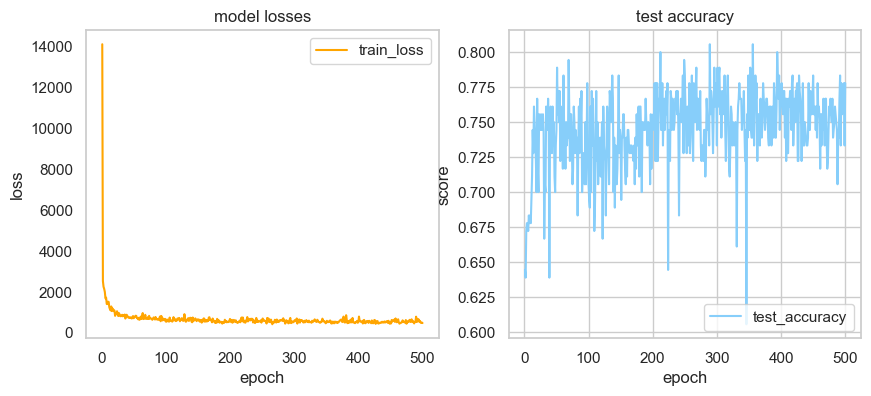

In [362]:
# Выводим графики обучения модели

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(loss_history.keys(), loss_history.values(), color='orange')
ax[0].set_title('model losses')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['train_loss'], loc='upper right')
ax[0].grid();

ax[1].plot(test_accuracy.keys(), test_accuracy.values(), color='lightskyblue')
ax[1].set_title('test accuracy')
ax[1].set_ylabel('score')
ax[1].set_xlabel('epoch')
ax[1].legend(['test_accuracy'], loc='lower right')
ax[1].grid()
plt.grid();

In [130]:
# Загружаем лучшую обученную модель, включаем ранее отключенные пайплайны

nlp = spacy.load('Kontur_nlp_v2')
for pipe in disabled_pipes:
    nlp.enable_pipe(pipe)
print(nlp.pipe_names)

['tok2vec', 'morphologizer', 'ner']


In [90]:
# Создаем отдельный датафрейм, в который поместим извлеченные моделью сущности, а также необходимые для дальнейших операций 
# столбцы из train

res = pd.DataFrame()
res['label'] = train.label
res['text'] = train.text
res['orig'] = train.extracted_part.apply(lambda x: x['text'][0])
res['pred'] = res.apply(lambda x: extract_text(nlp, x.text, x.label), axis=1)
res['coincidence'] = res.orig == res.pred
res.head()

,label,text,orig,pred,coincidence
0,обеспечение исполнения контракта,Извещение о проведении открытого конкурса в эл...,Размер обеспечения исполнения контракта 6593.2...,Размер обеспечения исполнения контракта 6593.2...,True
1,обеспечение исполнения контракта,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,Поставщик должен предоставить обеспечение испо...,Поставщик должен предоставить обеспечение испо...,True
2,обеспечение исполнения контракта,Извещение о проведении электронного аукциона д...,Размер обеспечения исполнения контракта 10.00%,Размер обеспечения исполнения контракта 10.00%,True
3,обеспечение исполнения контракта,Извещение о проведении электронного аукциона д...,Размер обеспечения исполнения контракта 10.00%,Размер обеспечения исполнения контракта 10.00%,True
4,обеспечение исполнения контракта,Извещение о проведении электронного аукциона д...,Размер обеспечения исполнения контракта 10.00%,Размер обеспечения исполнения контракта 10.00%,True


In [ ]:
# Создадим шаблоны, по которым EntityRuler будет выполнять поиск совпадений и извлекать найденные сущности,
# которые не удалось извлечь с помощью ner

In [98]:
# В 2 списка вносим сущности, которые были извлечены неправильно

wrong_entities = res['orig'][res.coincidence == False].tolist()
wrong_entities_labels = res['label'][res.coincidence == False].tolist()

In [99]:
# Для создания списка шаблонов на этом шаге разделяем токены на соответствующие группы - LIKE_NUM, IS_PUNCT и слова,
# которые будут вноситься в шаблон

patterns_data = []

for i in tqdm(range(len(wrong_entities))):
    doc = nlp(wrong_entities[i])
    one_obj_pattern = []
    for i, elem in enumerate([token.text for token in doc]):
        word = re.sub(r'[^А-Яа-яё]', '', elem)
        punct = ''.join(re.findall(r'(?:[^\s\w]|_)+', elem))
        num = ''.join(re.findall(r'\b\d+(?:[,.]\d+)*\b', elem))
        if nlp(elem)[0].pos_ == 'NUM' or elem == num:
            one_obj_pattern.append('LIKE_NUM')
        elif elem == punct:
            one_obj_pattern.append('IS_PUNCT')
        else:
            one_obj_pattern.append(elem.lower())
    patterns_data.append(one_obj_pattern)
print(patterns_data[0])

100%|████████████████████████████████████████████████████████████████████████████████| 133/133 [00:09<00:00, 13.85it/s]

['размер', 'обеспечения', 'исполнения', 'контракта', 'устанавливается', 'в', 'размере', 'LIKE_NUM', 'IS_PUNCT', 'LIKE_NUM', 'IS_PUNCT', 'процентов', 'от', 'цены', 'IS_PUNCT', 'по', 'которой', 'заключается', 'контракт', 'и', 'составляет', 'IS_PUNCT', 'IS_PUNCT', 'IS_PUNCT']


In [118]:
# Создаем шаблоны из размеченных извлеченных сущностей

patterns = []

for idx, row in enumerate(patterns_data):
    one_obj_pattern = []
    reversed_row = row[::-1]
    OP = 0
    for i, token in enumerate(reversed_row):
        if token not in ['IS_PUNCT', 'LIKE_NUM']:
            one_obj_pattern.append({'LOWER': token.lower()})
        else:
            OP += 1
            flag = 0 if set(reversed_row[:i+1]) == {'IS_PUNCT'} else 1
            try:
                next_toc = reversed_row[i+1]
            except:
                next_toc = ''
            if next_toc != token:
                OP = str({OP}) if (flag == 0 and token == 'IS_PUNCT') else '*'
                one_obj_pattern.append({token: True, 'OP': OP})
                OP = 0
    pattern = {'label': wrong_entities_labels[idx], 'pattern': one_obj_pattern[::-1]}
    if pattern not in patterns:
        patterns.append(pattern)
patterns[0]

{'label': 'обеспечение исполнения контракта',
 'pattern': [{'LOWER': 'размер'},
  {'LOWER': 'обеспечения'},
  {'LOWER': 'исполнения'},
  {'LOWER': 'контракта'},
  {'LOWER': 'устанавливается'},
  {'LOWER': 'в'},
  {'LOWER': 'размере'},
  {'LIKE_NUM': True, 'OP': '*'},
  {'IS_PUNCT': True, 'OP': '*'},
  {'LIKE_NUM': True, 'OP': '*'},
  {'IS_PUNCT': True, 'OP': '*'},
  {'LOWER': 'процентов'},
  {'LOWER': 'от'},
  {'LOWER': 'цены'},
  {'IS_PUNCT': True, 'OP': '*'},
  {'LOWER': 'по'},
  {'LOWER': 'которой'},
  {'LOWER': 'заключается'},
  {'LOWER': 'контракт'},
  {'LOWER': 'и'},
  {'LOWER': 'составляет'},
  {'IS_PUNCT': True, 'OP': '{3}'}]}

# Evaluation

In [88]:
# Рассмотрим 3 варианта моделей: модель только с ner без entity_ruler, а также 2 модели с разной очередностью пайплайнов - 
# entity_ruler до и после ner

In [57]:
# Метрики обученной модели Spacy NER

train_accuracy = accuracy_score(nlp, train_sample[['text', 'label', 'extra_text']])
print('train_accuracy:', train_accuracy)
val_accuracy = accuracy_score(nlp, val_sample[['text', 'label', 'extra_text']])
print('val_accuracy:', val_accuracy)

train_accuracy: 0.9401
val_accuracy: 0.8


In [131]:
# Добавляем entity_ruler перед ner и добавляем в него шаблоны, созданные ранее

entity_ruler = EntityRuler(nlp)
nlp.add_pipe('entity_ruler', before='ner')
entity_ruler = nlp.get_pipe("entity_ruler")
entity_ruler.add_patterns(patterns)
print(nlp.pipe_names)

['tok2vec', 'morphologizer', 'entity_ruler', 'ner']


In [132]:
# Проверяем метрику accuracy на тренировочной и валидационной выборке

train_accuracy = accuracy_score(nlp, train_sample[['text', 'label', 'extra_text']])
print('train_accuracy:', train_accuracy)
val_accuracy = accuracy_score(nlp, val_sample[['text', 'label', 'extra_text']])
print('val_accuracy:', val_accuracy)

train_accuracy: 0.9642
val_accuracy: 0.9278


In [121]:
# Удаляем entity_ruler, добавленный ранее перед ner и добавляем entity_ruler после ner, добавляем в него шаблоны

nlp.remove_pipe("entity_ruler")
entity_ruler = EntityRuler(nlp, overwrite_ents=True)
nlp.add_pipe('entity_ruler', last=True)
entity_ruler = nlp.get_pipe("entity_ruler")
entity_ruler.add_patterns(patterns)
print(nlp.pipe_names)

['tok2vec', 'morphologizer', 'ner', 'entity_ruler']


In [122]:
# Проверяем метрику accuracy на тренировочной и валидационной (тестовой) выборке для второго варианта

train_accuracy = accuracy_score(nlp, train_sample[['text', 'label', 'extra_text']])
print('train_accuracy:', train_accuracy)
val_accuracy = accuracy_score(nlp, val_sample[['text', 'label', 'extra_text']])
print('val_accuracy:', val_accuracy)

train_accuracy: 0.9568
val_accuracy: 0.8722


In [133]:
# Лучший результат у модели последовательностью пайплайнов entity_ruler - ner. Сохраняем ее на диск. Извлечение сущностей из 
# тестовой выборки будем выполнять с помощью этой модели

nlp.meta["name"] = "Kontur_nlp_test_task_final_model"
nlp.to_disk('C://Users/Konstantin/Documents/Стажировки и тестовые/Kontur_test_task/solution/Kontur_nlp_test_task_final_model')

# Prediction

In [15]:
# Загружаем лучшую обученную модель

nlp = spacy.load('Kontur_nlp_test_task_final_model')
print(nlp.pipe_names)

['tok2vec', 'morphologizer', 'entity_ruler', 'ner']


In [16]:
# Загружаем тестовые данные

test = pd.read_json('test.json')
test.head()

,id,text,label
0,762883279,МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание ус...,обеспечение исполнения контракта
1,311837655,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта
2,540954893,Идентификационный код закупки: 222633005300163...,обеспечение исполнения контракта
3,274660397,Идентификационный код закупки: 222631202689463...,обеспечение исполнения контракта
4,732742591,Идентификационный код закупки: 222637800031163...,обеспечение исполнения контракта


In [17]:
# Сделаем предсказание для тестовой выборки

test['predict'] = test.apply(lambda x: extract_text(nlp, x.text, x.label), axis=1)
test.head()

,id,text,label,predict
0,762883279,МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание ус...,обеспечение исполнения контракта,Размер обеспечения исполнения Контракта состав...
1,311837655,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,Размер обеспечения исполнения контракта 10.00%
2,540954893,Идентификационный код закупки: 222633005300163...,обеспечение исполнения контракта,Размер обеспечение исполнения контракта устана...
3,274660397,Идентификационный код закупки: 222631202689463...,обеспечение исполнения контракта,Размер обеспечение исполнения контракта устана...
4,732742591,Идентификационный код закупки: 222637800031163...,обеспечение исполнения контракта,Размер обеспечение исполнения контракта устана...


In [18]:
# Выделим в тексте извлеченные фрагменты с помощью инструмента для визуализации displacy и преобразуем предсказание модели 
# в требуемый формат, а также удаляем лишние столбцы

test['extracted_part'] = ''
for i, row in test.iterrows():
    start = row.text.find(row.predict)
    end = row.text.find(row.predict) + len(row.predict)
    test['extracted_part'][i] = {'text': [row.predict], 'answer_start': [start], 'answer_end': [end]}
    
    if row['predict'] != '':
        text = row['text']
        label = row['label']
        doc={'ents': [{'end': end, 'start': start, 'label': label}], 'text': text}
        displacy.render(doc, style="ent", manual=True, jupyter=True) 

In [9]:
test.drop(columns='predict', inplace=True)
test.head()

,id,text,label,extracted_part
0,762883279,МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание ус...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения Контр...
1,311837655,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...
2,540954893,Идентификационный код закупки: 222633005300163...,обеспечение исполнения контракта,{'text': ['Размер обеспечение исполнения контр...
3,274660397,Идентификационный код закупки: 222631202689463...,обеспечение исполнения контракта,{'text': ['Размер обеспечение исполнения контр...
4,732742591,Идентификационный код закупки: 222637800031163...,обеспечение исполнения контракта,{'text': ['Размер обеспечение исполнения контр...


In [13]:
# Сохраняем предсказание модели в файл

path = 'C://Users/Konstantin/Documents/Стажировки и тестовые/Kontur_test_task/predictions.json'
test.to_json(path_or_buf=path, orient="records", force_ascii=False)